In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sb
import statsmodels.api as sm
import plotly.express as px
import kaleido
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from collections import Counter
import plotly.io as pio


## Read the data

In [2]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['inr(10e3)'] = df['PriceEuro']*0.08320
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
df['PowerTrain'].replace(to_replace=['AWD','RWD','FWD'],value=[0, 1,2],inplace=True)
df.head()

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\2291704227.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\2291704227.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

Brand                          Model  AccelSec  TopSpeed_KmH  \
0       Tesla   Model 3 Long Range Dual Motor       4.6           233   
1  Volkswagen                       ID.3 Pure      10.0           160   
2    Polestar                               2       4.7           210   
3         BMW                            iX3        6.8           180   
4       Honda                              e        9.5           145   

   Range_Km  Efficiency_WhKm  FastCharge_KmH  RapidCharge  PowerTrain  \
0       450              161             940            1           0   
1       270              167             250            0           1   
2       400              181             620            1           0   
3       360              206             560            1           1   
4       170              168             190            1           1   

     PlugType  BodyStyle Segment  Seats  PriceEuro  inr(10e3)  
0  Type 2 CCS      Sedan       D      5      55480  4615.9360  
1  Type 2 CCS  Hatchback       C      5      30000  2496.0000  
2  Type 2 CCS   Liftback       D      5      56440  4695.8080  
3  Type 2 CCS        SUV       D      5      68040  5660.9280  
4  Type 2 CCS  Hatchback       B      4      32997  2745.3504

In [3]:
df["PowerTrain"].unique()

array([0, 1, 2], dtype=int64)

In [4]:
df[(df['Brand'] == 'Tesla ') | (df['Brand'] == 'BMW ')]

Brand                           Model  AccelSec  TopSpeed_KmH  Range_Km  \
0   Tesla    Model 3 Long Range Dual Motor       4.6           233       450   
3     BMW                             iX3        6.8           180       360   
8   Tesla      Model 3 Standard Range Plus       5.6           225       310   
13    BMW                              i4        4.0           200       450   
21  Tesla    Model Y Long Range Dual Motor       5.1           217       425   
24  Tesla   Model 3 Long Range Performance       3.4           261       435   
28    BMW                        i3 120 Ah       7.3           150       235   
33  Tesla             Cybertruck Tri Motor       3.0           210       750   
40  Tesla               Model S Long Range       3.8           250       515   
51  Tesla                        Roadster        2.1           410       970   
54  Tesla               Model X Long Range       4.6           250       450   
59  Tesla              Model S Performance       2.5           261       505   
61  Tesla   Model Y Long Range Performance       3.7           241       410   
67  Tesla            Cybertruck Dual Motor       5.0           190       460   
70    BMW                       i3s 120 Ah       6.9           160       230   
81  Tesla              Model X Performance       2.8           250       440   
86  Tesla          Cybertruck Single Motor       7.0           180       390   

    Efficiency_WhKm  FastCharge_KmH  RapidCharge  PowerTrain    PlugType  \
0               161             940            1           0  Type 2 CCS   
3               206             560            1           1  Type 2 CCS   
8               153             650            1           1  Type 2 CCS   
13              178             650            1           1  Type 2 CCS   
21              171             930            1           0  Type 2 CCS   
24              167             910            1           0  Type 2 CCS   
28              161             270            0           1  Type 2 CCS   
33              267             710            1           0  Type 2 CCS   
40              184             560            1           0      Type 2   
51              206             920            1           0  Type 2 CCS   
54              211             490            1           0      Type 2   
59              188             550            1           0      Type 2   
61              177             900            1           0  Type 2 CCS   
67              261             710            1           0  Type 2 CCS   
70              165             260            1           1  Type 2 CCS   
81              216             480            1           0      Type 2   
86              256             740            0           1  Type 2 CCS   

    BodyStyle Segment  Seats  PriceEuro   inr(10e3)  
0       Sedan       D      5      55480   4615.9360  
3         SUV       D      5      68040   5660.9280  
8       Sedan       D      5      46380   3858.8160  
13      Sedan       D      5      65000   5408.0000  
21        SUV       D      7      58620   4877.1840  
24      Sedan       D      5      61480   5115.1360  
28  Hatchback       B      4      38017   3163.0144  
33     Pickup       N      6      75000   6240.0000  
40   Liftback       F      5      79990   6655.1680  
51     Cabrio       S      4     215000  17888.0000  
54        SUV       F      7      85990   7154.3680  
59   Liftback       F      5      96990   8069.5680  
61        SUV       D      7      65620   5459.5840  
67     Pickup       N      6      55000   4576.0000  
70  Hatchback       B      4      41526   3454.9632  
81        SUV       F      7     102990   8568.7680  
86     Pickup       N      6      45000   3744.0000

## Information of the type of data in seach column

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    int64  
 7   RapidCharge      103 non-null    int64  
 8   PowerTrain       103 non-null    int64  
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
 14  inr(10e3)        103 non-null    float64
dtypes: float64(2), int64(8), object(5)
memory usage: 12.2+ KB


## Finding out the number of null values

In [6]:
df.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

## Descriptive Statistics of the dataset

In [7]:
df.describe()

AccelSec  TopSpeed_KmH    Range_Km  Efficiency_WhKm  FastCharge_KmH  \
count  103.000000    103.000000  103.000000       103.000000      103.000000   
mean     7.396117    179.194175  338.786408       189.165049      444.271845   
std      3.017430     43.573030  126.014444        29.566839      203.949253   
min      2.100000    123.000000   95.000000       104.000000      170.000000   
25%      5.100000    150.000000  250.000000       168.000000      260.000000   
50%      7.300000    160.000000  340.000000       180.000000      440.000000   
75%      9.000000    200.000000  400.000000       203.000000      555.000000   
max     22.400000    410.000000  970.000000       273.000000      940.000000   

       RapidCharge  PowerTrain       Seats      PriceEuro     inr(10e3)  
count   103.000000  103.000000  103.000000     103.000000    103.000000  
mean      0.747573    0.961165    4.883495   55811.563107   4643.522050  
std       0.436529    0.873603    0.795834   34134.665280   2840.004151  
min       0.000000    0.000000    2.000000   20129.000000   1674.732800  
25%       0.500000    0.000000    5.000000   34429.500000   2864.534400  
50%       1.000000    1.000000    5.000000   45000.000000   3744.000000  
75%       1.000000    2.000000    5.000000   65000.000000   5408.000000  
max       1.000000    2.000000    7.000000  215000.000000  17888.000000

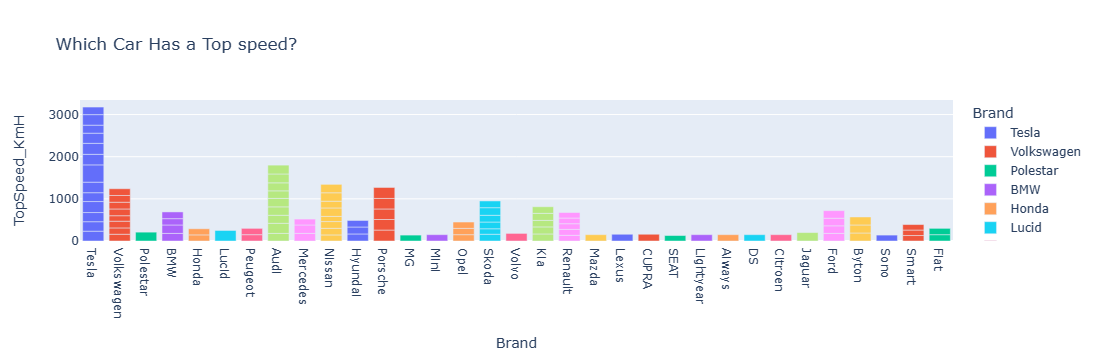

In [8]:
fig = px.bar(df,x='Brand',y = 'TopSpeed_KmH',color = 'Brand',title = 'Which Car Has a Top speed?',labels = {'x':'Car Brands','y':'Top Speed Km/H'})
pio.show(fig)

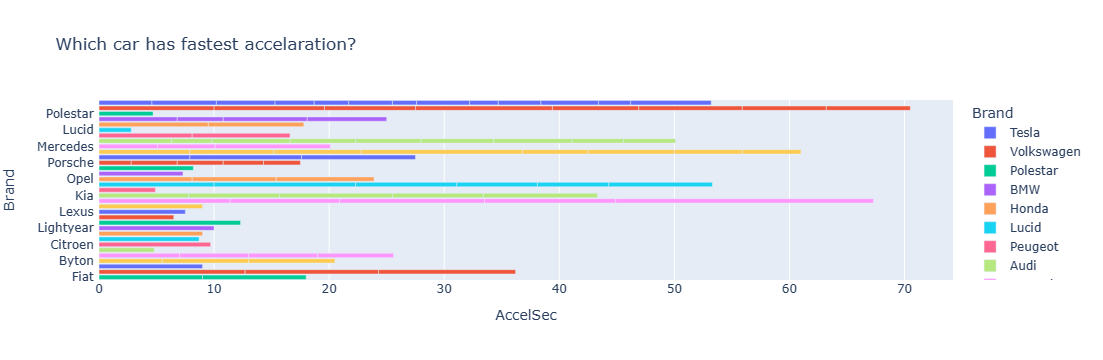

In [9]:
fig = px.bar(df,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Which car has fastest accelaration?',labels = {'x':'Accelaration','y':'Car Brands'})
pio.show(fig)

<Axes: title={'center': 'Car Price'}, xlabel='No. of Samples', ylabel='Car Price'>

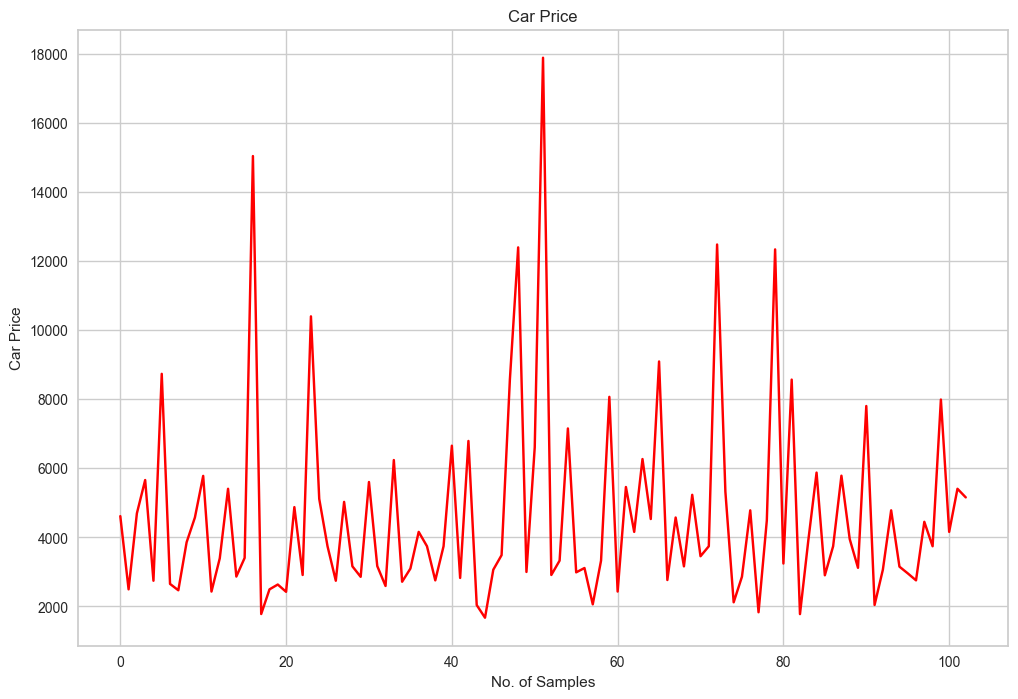

In [10]:
df['inr(10e3)'].plot(figsize = (12,8),title='Car Price',xlabel = 'No. of Samples',ylabel = 'Car Price',color = 'red')

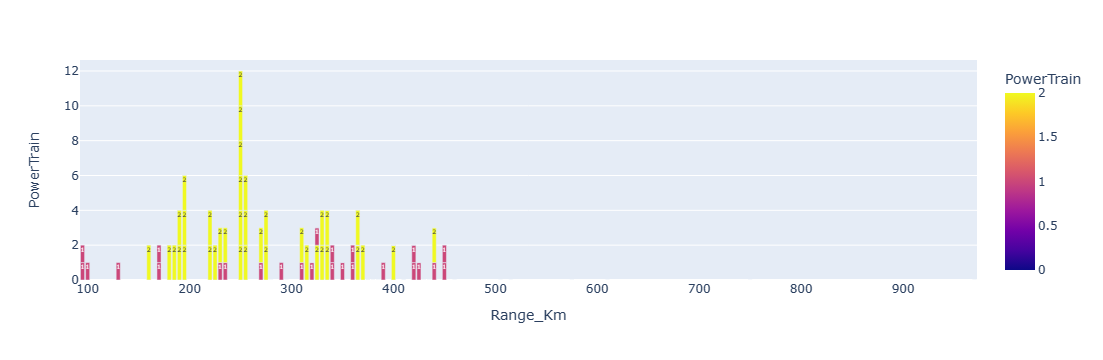

In [11]:
fig = px.bar(df,x = 'Range_Km',y = 'PowerTrain',color = 'PowerTrain',text='PowerTrain')
pio.show(fig)

C:\Users\asifi\miniconda3\envs\basic\Lib\site-packages\plotly\express\_core.py:1991: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



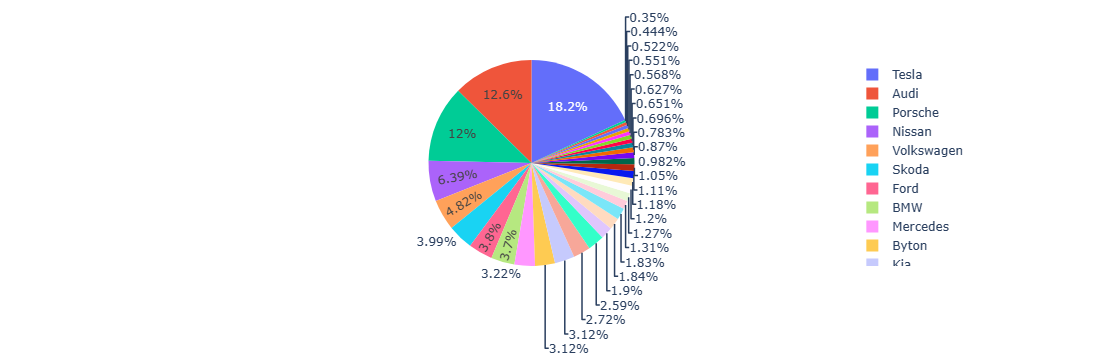

In [12]:
fig = px.pie(df,names = 'Brand',values = 'inr(10e3)')
pio.show(fig)

In [13]:
fig = px.scatter_3d(df,x = 'Brand',y = 'Seats',z = 'Segment',color='Brand')

In [14]:
fig = px.scatter_3d(df,x = 'Brand',y = 'AccelSec',z = 'inr(10e3)',color = 'Brand')

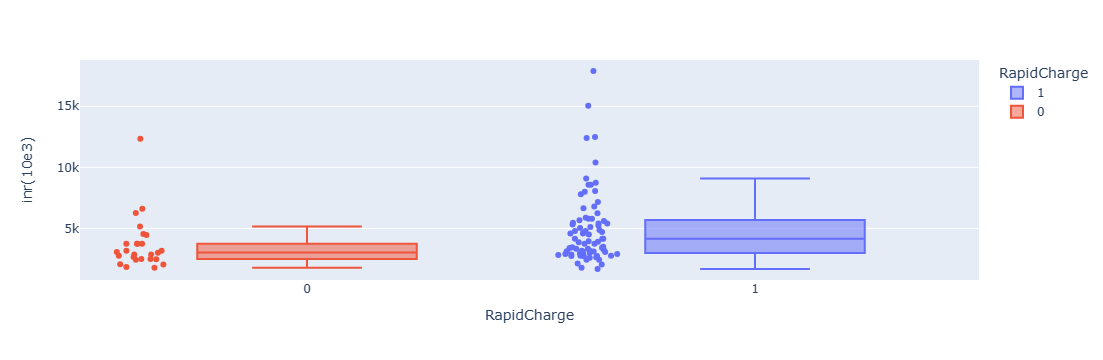

In [15]:
fig = px.box(df,x='RapidCharge',y = 'inr(10e3)',color = 'RapidCharge',points='all')
pio.show(fig)

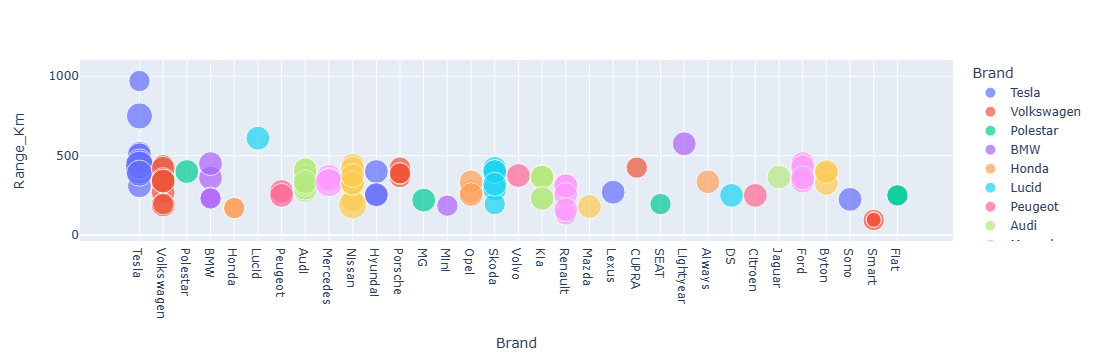

In [16]:
fig = px.scatter(df,x = 'Brand',y = 'Range_Km',size='Seats',color = 'Brand',hover_data=['RapidCharge','inr(10e3)'])
pio.show(fig)

## Pairplot of all the columns based on Rapid Charger presence

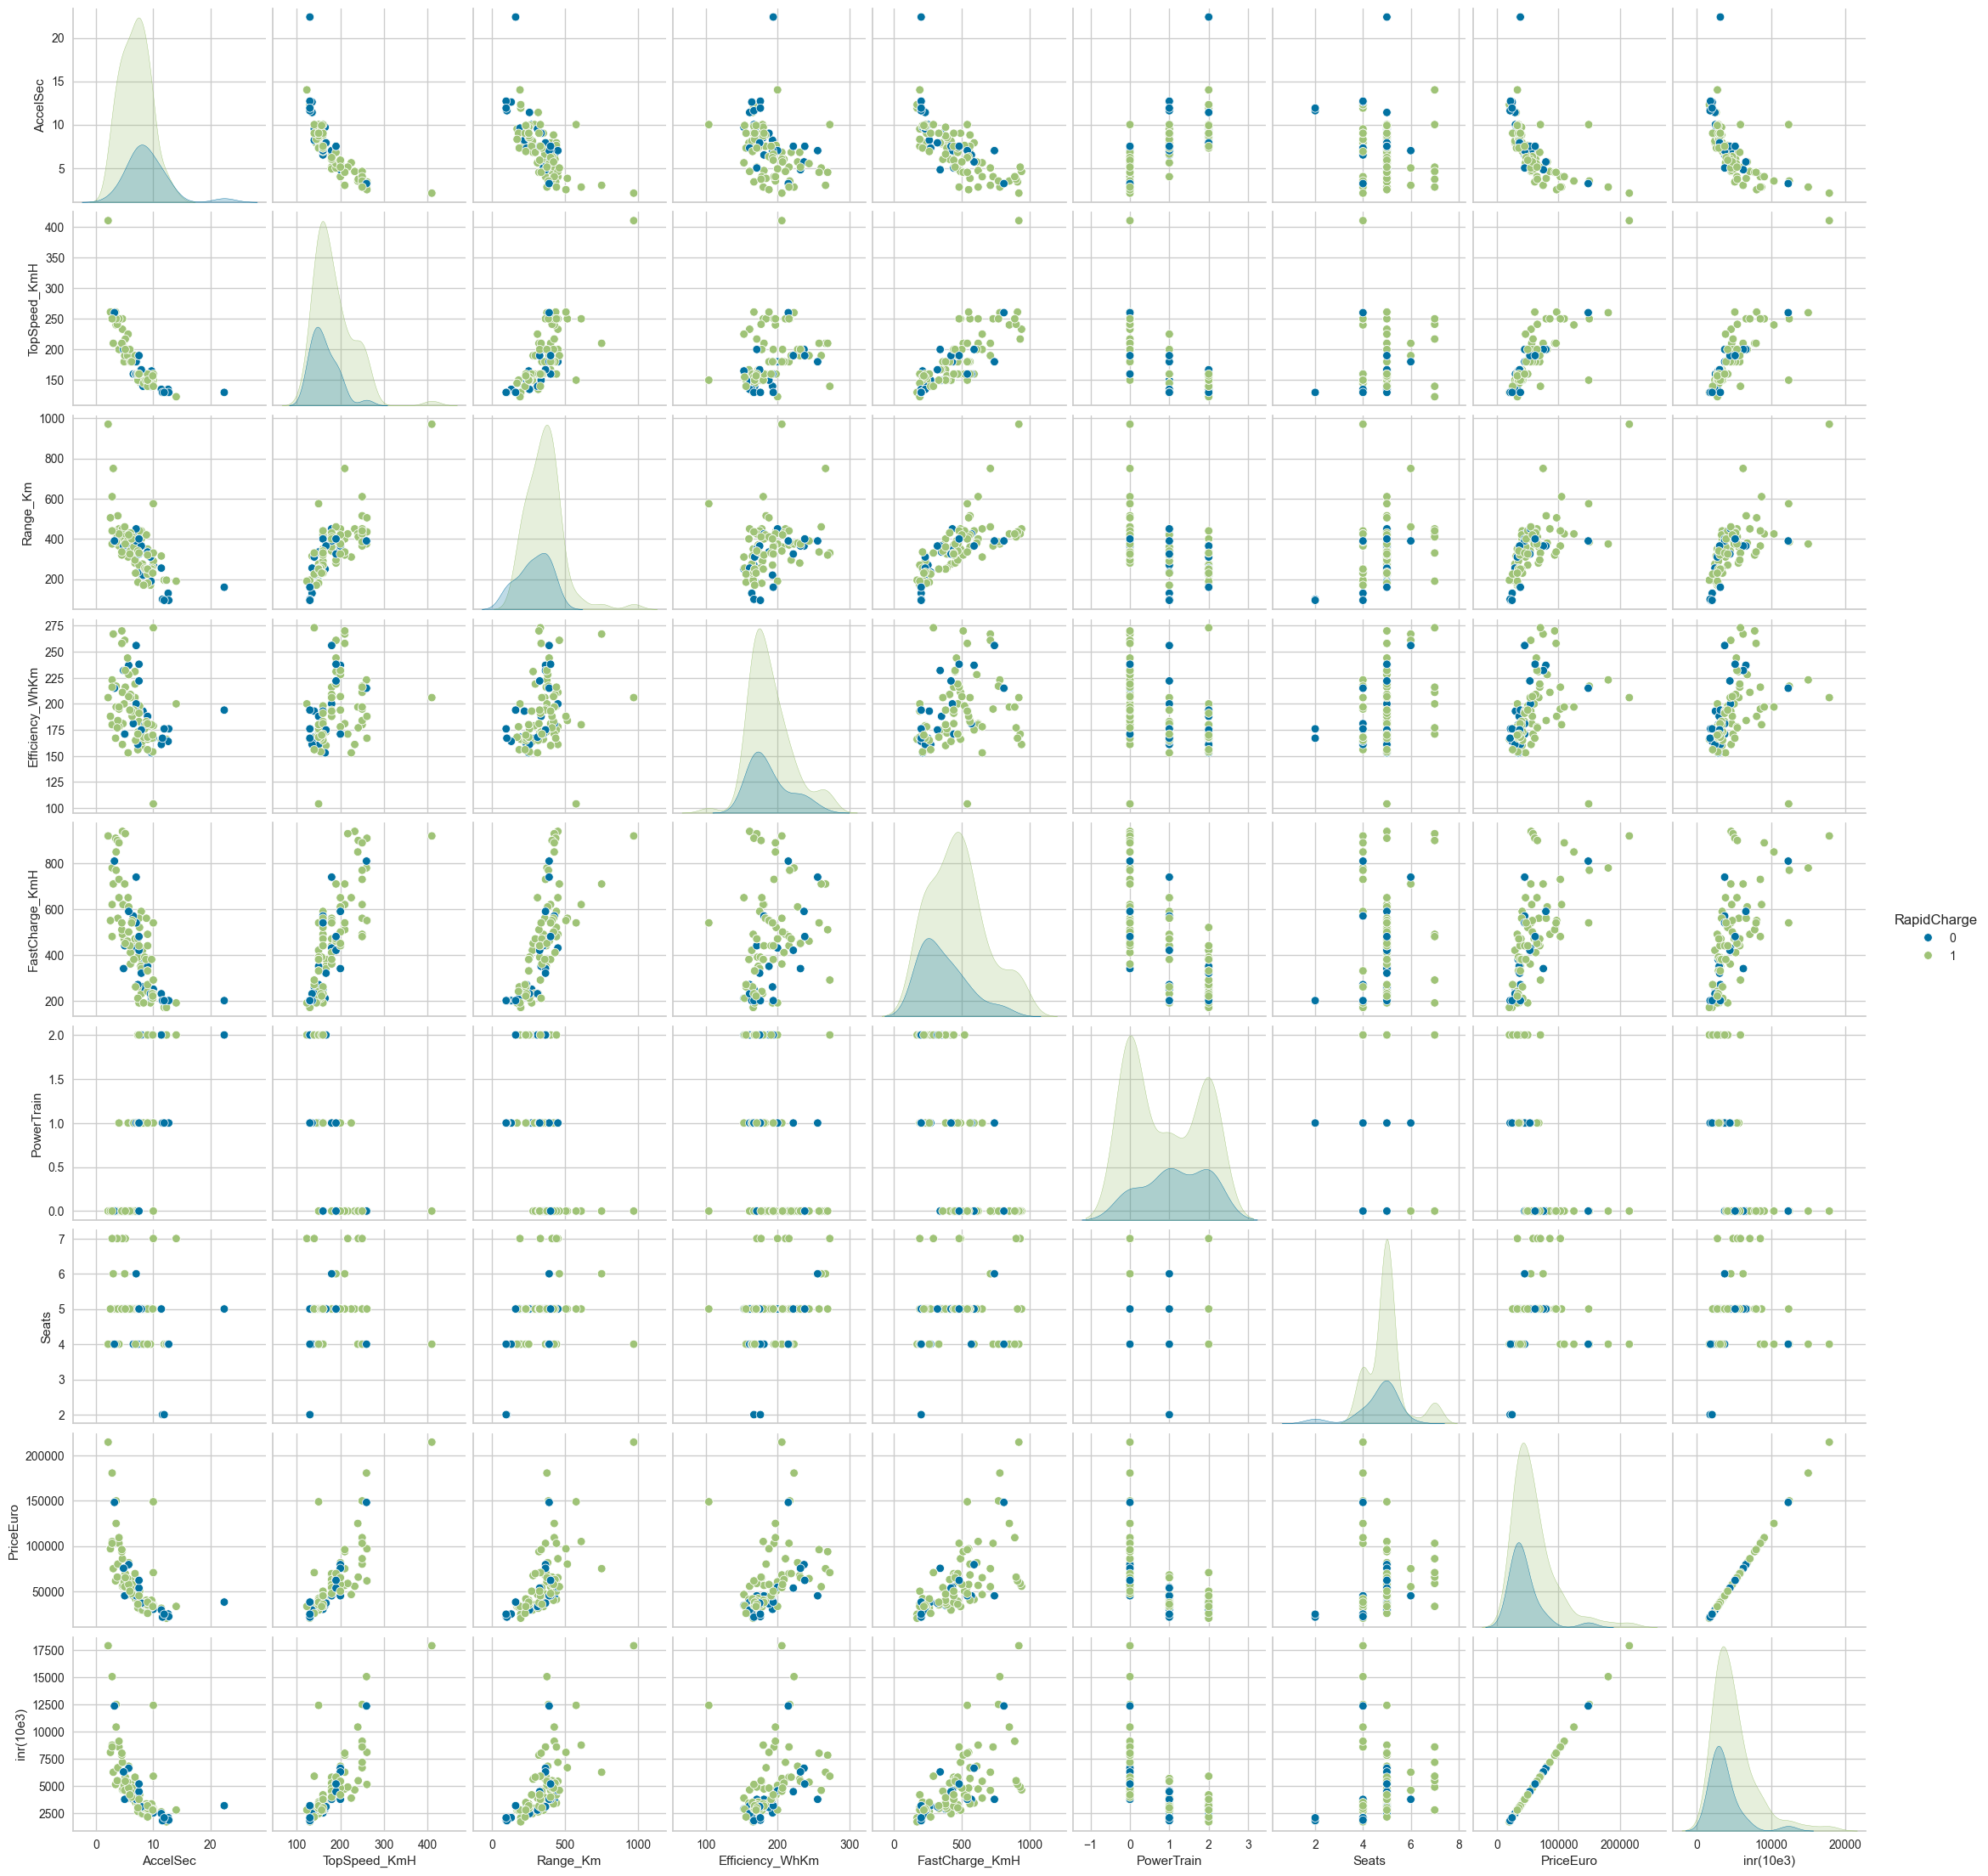

In [17]:
sb.pairplot(df,hue='RapidCharge')

## Heatmap to show the correlation of the data

<Axes: >

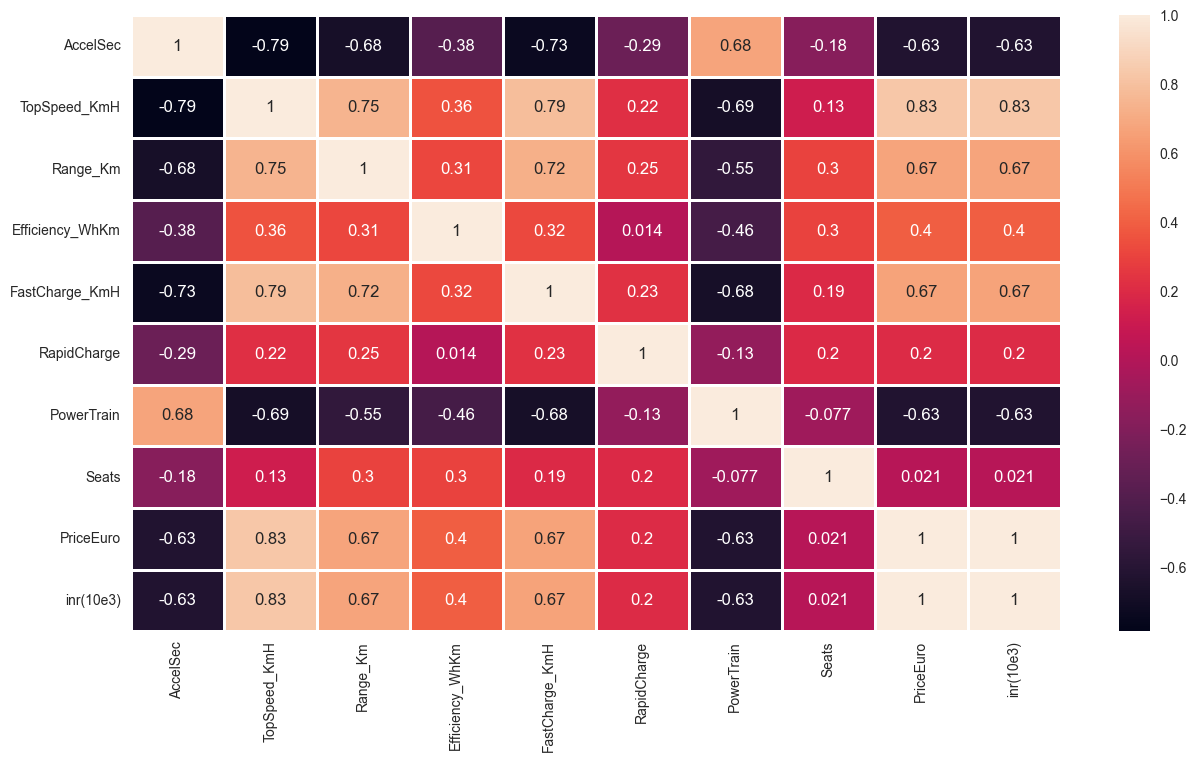

In [18]:
ax= plt.figure(figsize=(15,8))
sb.heatmap(df.corr( numeric_only=True),linewidths=1,linecolor='white',annot=True)

In [19]:
a=np.arange(1,104)

# Making Some Comparisions for our dataset


## Frequency of the Brands in the dataset

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

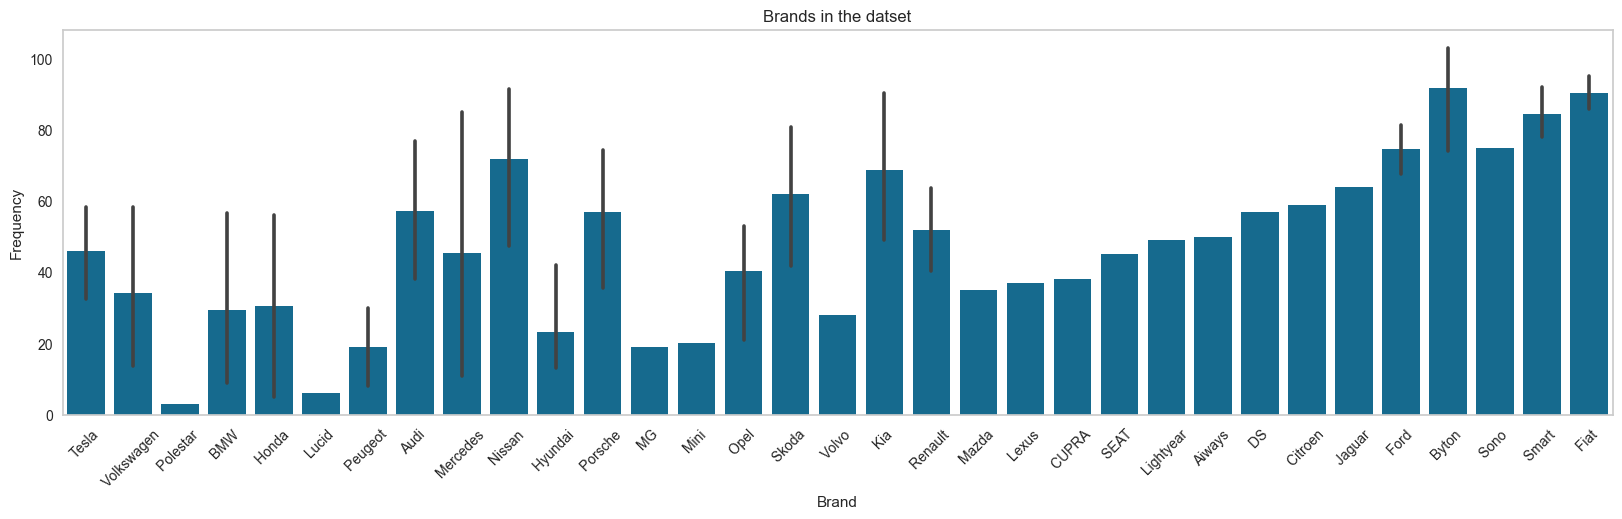

In [20]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y=a,data=df)
plt.grid(axis='y')
plt.title('Brands in the datset')
plt.xlabel('Brand')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Byton , Fiat and smart are the prominent brands and Polestar being the least


## Top speeds achieved by the cars of a brand

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\3803754215.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

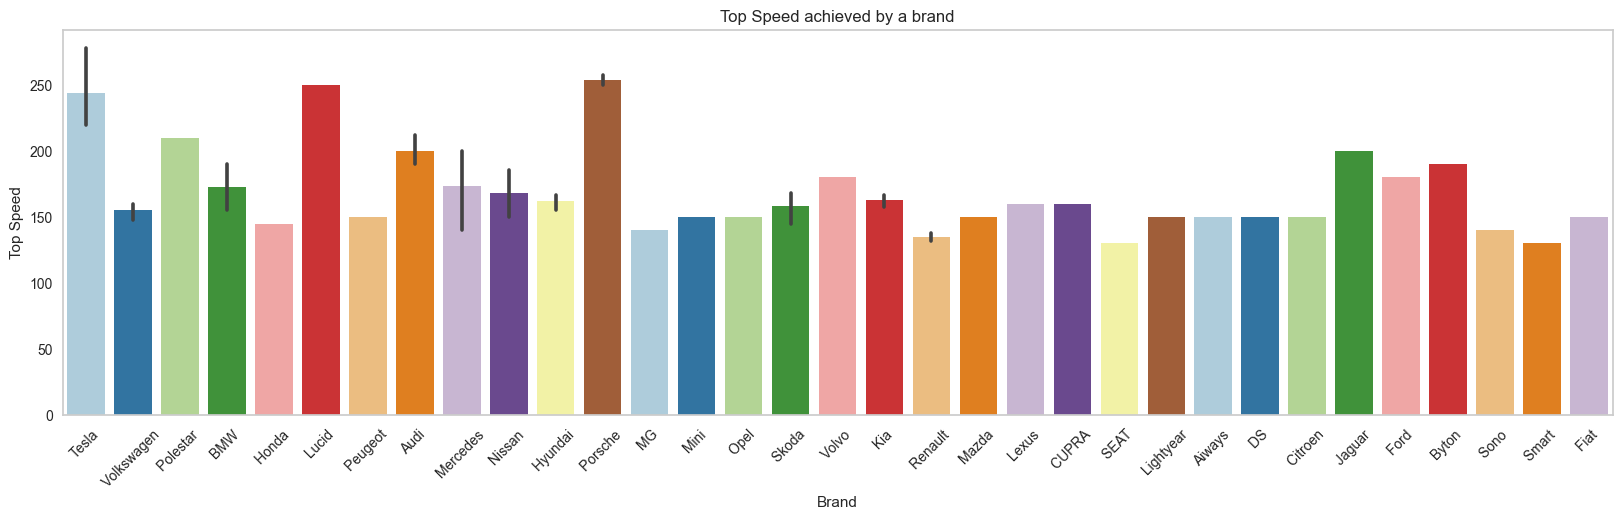

In [21]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='TopSpeed_KmH',data=df,palette='Paired')
plt.grid(axis='y')
plt.title('Top Speed achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Top Speed')
plt.xticks(rotation=45)

Porsche, Lucid and Tesla produce the fastest cars and Smart the lowest


## Range a car can achieve

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\86823407.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

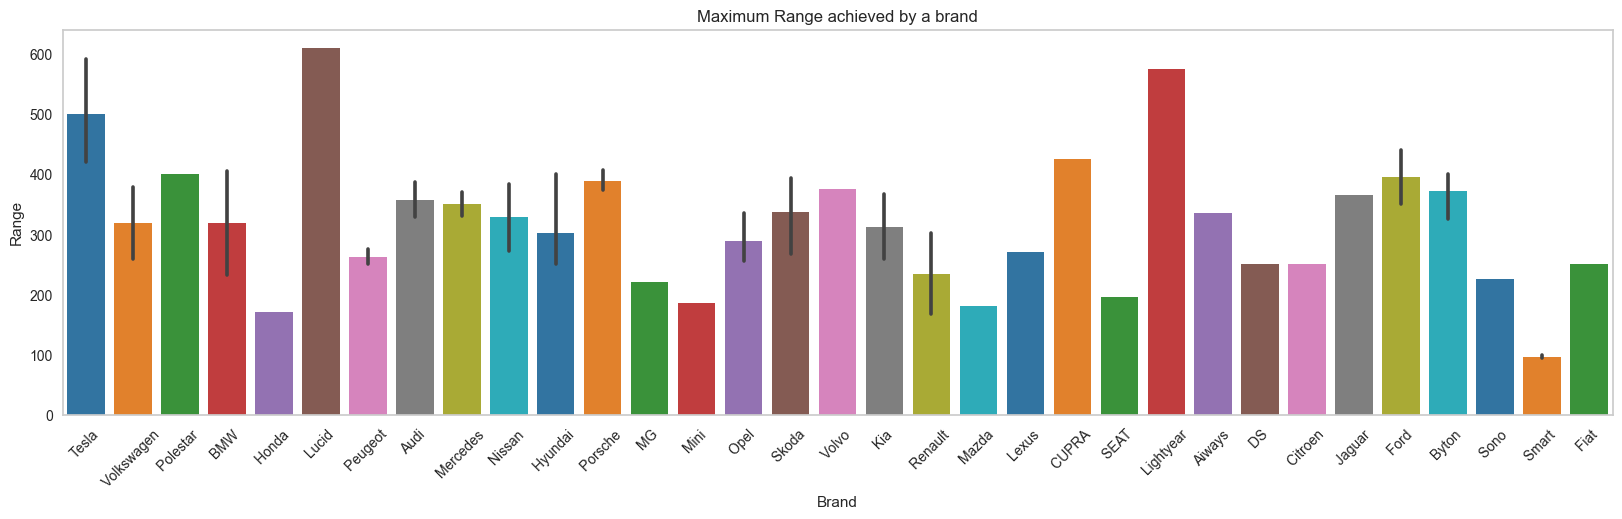

In [22]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Range_Km',data=df,palette='tab10')
plt.grid(axis='y')
plt.title('Maximum Range achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Range')
plt.xticks(rotation=45)

Lucid, Lightyear and Tesla have the highest range and Smart the lowest

## Car efficiency

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\4084309128.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

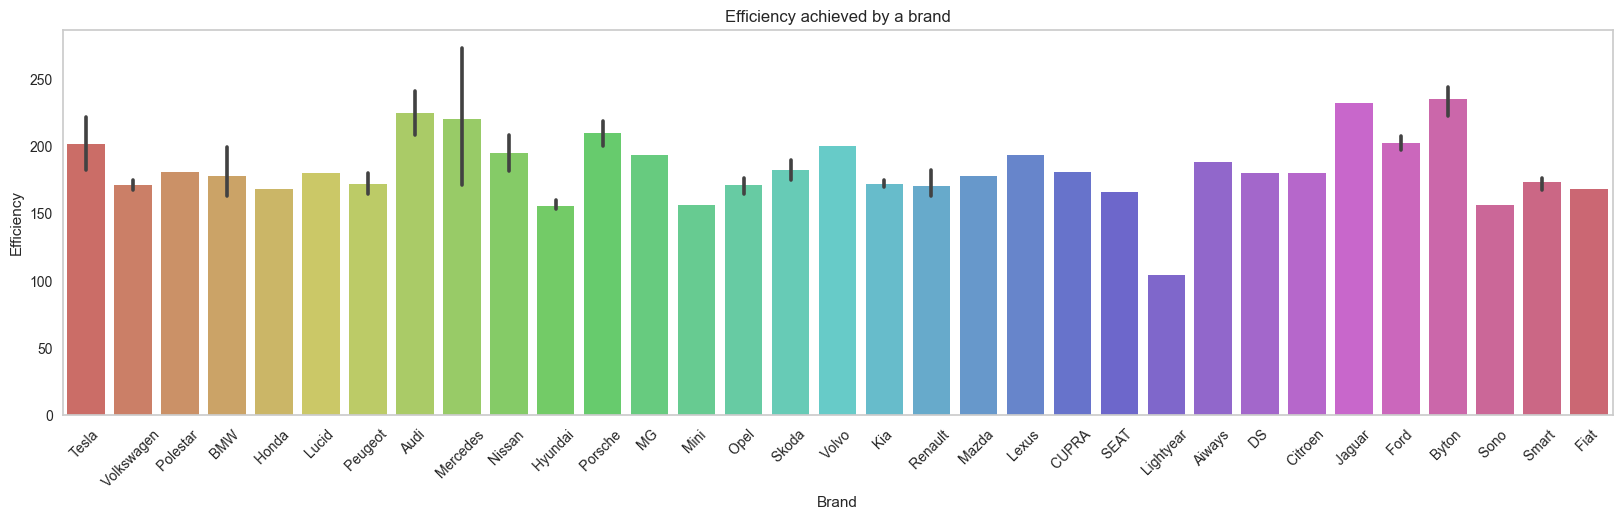

In [23]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Efficiency_WhKm',data=df,palette='hls')
plt.grid(axis='y')
plt.title('Efficiency achieved by a brand')
plt.xlabel('Brand')
plt.ylabel('Efficiency')
plt.xticks(rotation=45)

Byton , Jaguar and Audi are the most efficient and Lightyear the least

## Number of seats in each car

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\1710699335.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

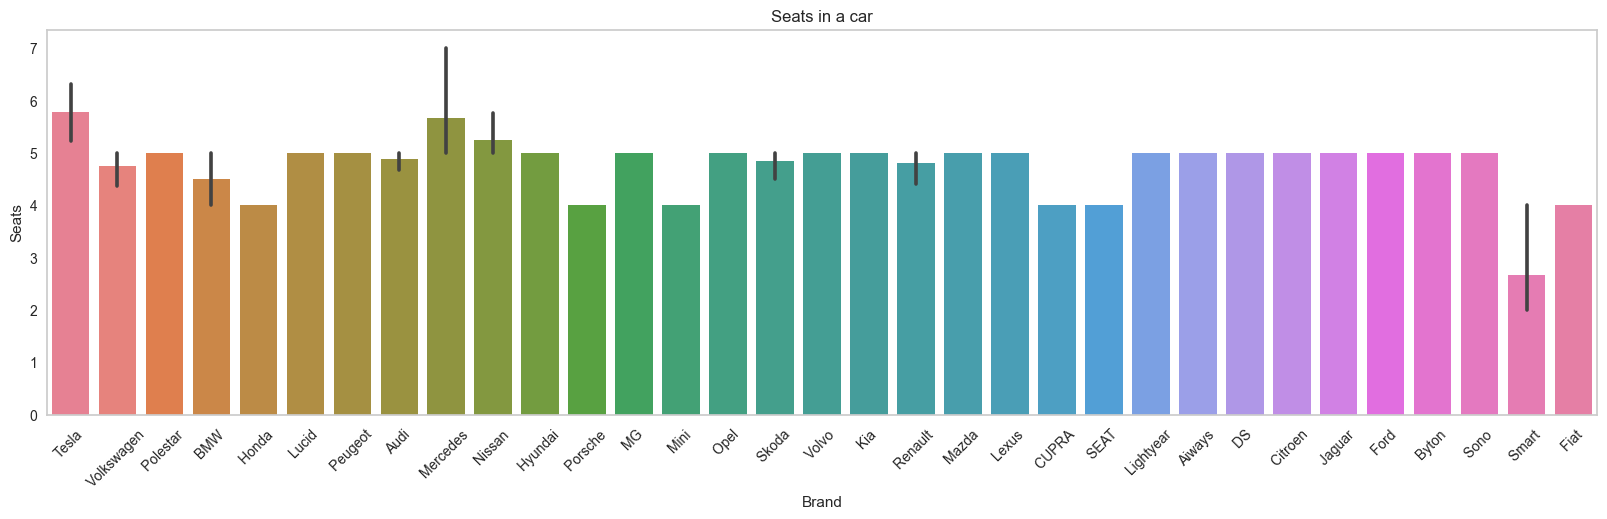

In [24]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='Seats',data=df,palette='husl')
plt.grid(axis='y')
plt.title('Seats in a car')
plt.xlabel('Brand')
plt.ylabel('Seats')
plt.xticks(rotation=45)

Mercedes, Tesla and Nissan have the highest number of seats and Smart the lowest

## Price of cars (in INR)

C:\Users\asifi\AppData\Local\Temp\ipykernel_13416\211908187.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32],
 [Text(0, 0, 'Tesla '),
  Text(1, 0, 'Volkswagen '),
  Text(2, 0, 'Polestar '),
  Text(3, 0, 'BMW '),
  Text(4, 0, 'Honda '),
  Text(5, 0, 'Lucid '),
  Text(6, 0, 'Peugeot '),
  Text(7, 0, 'Audi '),
  Text(8, 0, 'Mercedes '),
  Text(9, 0, 'Nissan '),
  Text(10, 0, 'Hyundai '),
  Text(11, 0, 'Porsche '),
  Text(12, 0, 'MG '),
  Text(13, 0, 'Mini '),
  Text(14, 0, 'Opel '),
  Text(15, 0, 'Skoda '),
  Text(16, 0, 'Volvo '),
  Text(17, 0, 'Kia '),
  Text(18, 0, 'Renault '),
  Text(19, 0, 'Mazda '),
  Text(20, 0, 'Lexus '),
  Text(21, 0, 'CUPRA '),
  Text(22, 0, 'SEAT '),
  Text(23, 0, 'Lightyear '),
  Text(24, 0, 'Aiways '),
  Text(25, 0, 'DS '),
  Text(26, 0, 'Citroen '),
  Text(27, 0, 'Jaguar '),
  Text(28, 0, 'Ford '),
  Text(29, 0, 'Byton '),
  Text(30, 0, 'Sono '),
  Text(31, 0, 'Smart '),
  Text(32

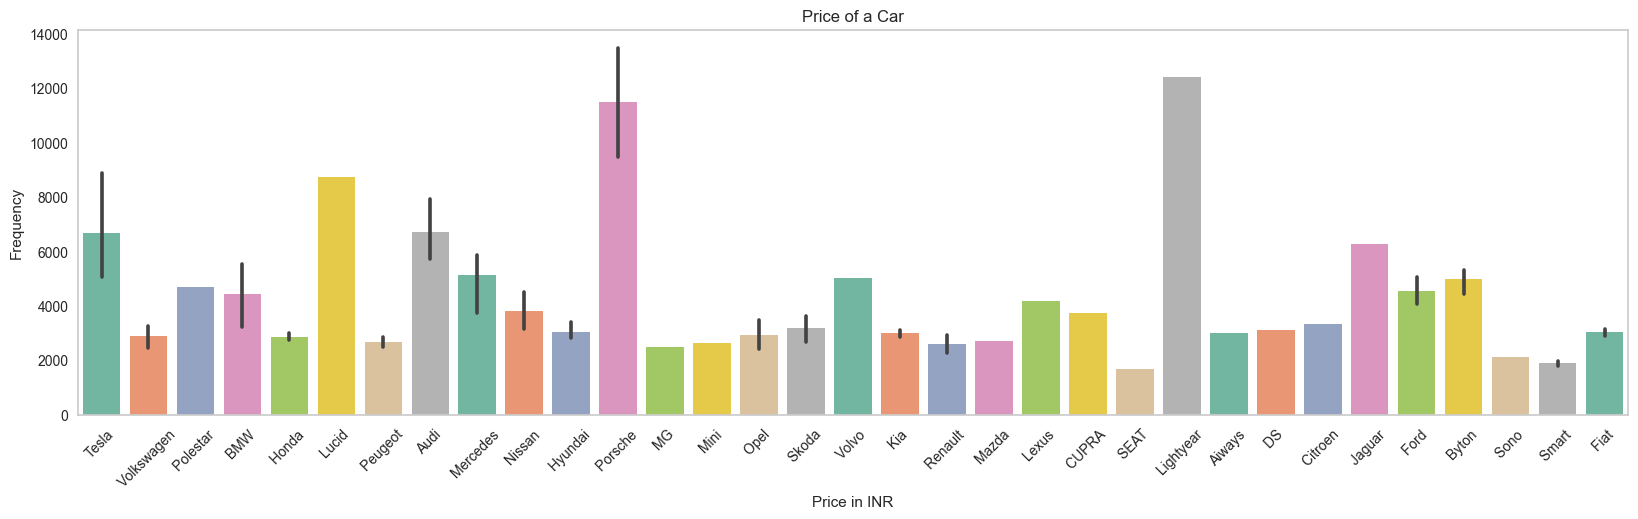

In [25]:
ax= plt.figure(figsize=(20,5))
sb.barplot(x='Brand',y='inr(10e3)',data=df,palette='Set2')
plt.title('Price of a Car')
plt.xlabel('Price in INR')
plt.grid(axis='y')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

Lightyear, Porsche and Lucid are the most expensive and SEAT and Smart the least

## Type of Plug used for charging

Text(0.5, 1.0, 'Plug Type')

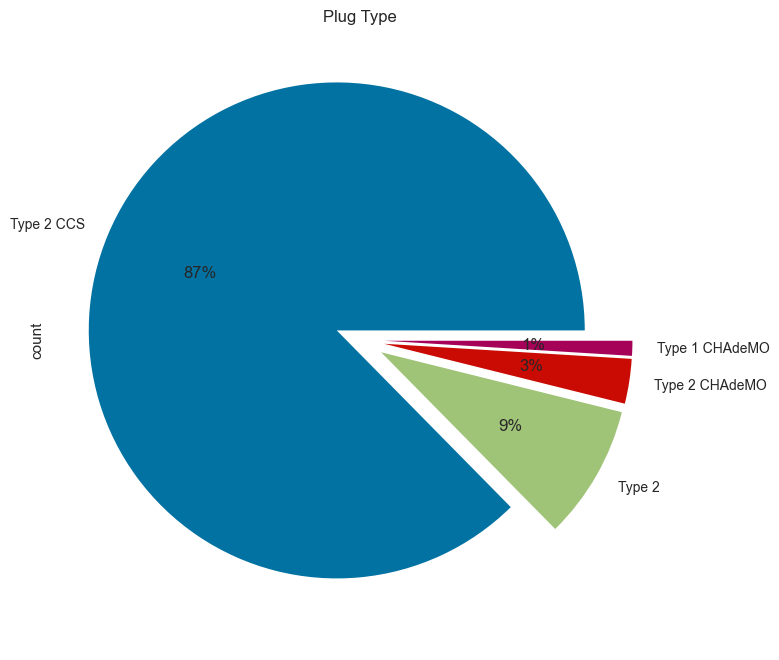

In [26]:
df['PlugType'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')

Most companies use Type 2 CCS and Type 1 CHAdeMo the least

## Cars and their body style

Text(0.5, 1.0, 'Body Style')

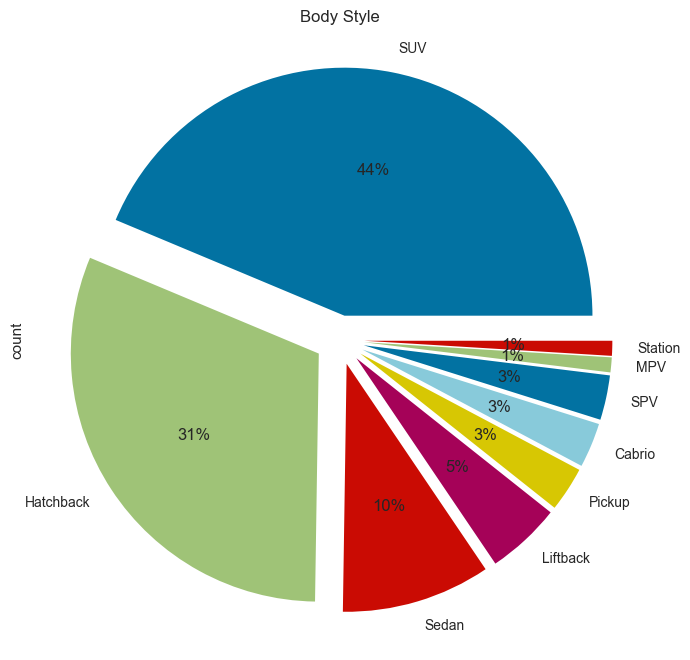

In [27]:
df['BodyStyle'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Body Style')

Most cars are eiher SUV or Hatchback

## Segment in which the cars fall under

Text(0.5, 1.0, 'Segment')

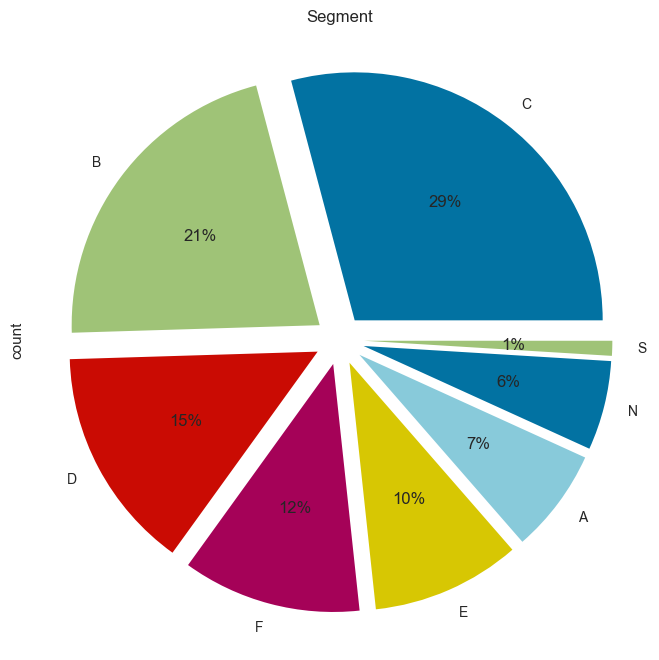

In [28]:
df['Segment'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Segment')

Most cars are either C or B type

## Number of Seats

Text(0.5, 1.0, 'Seats')

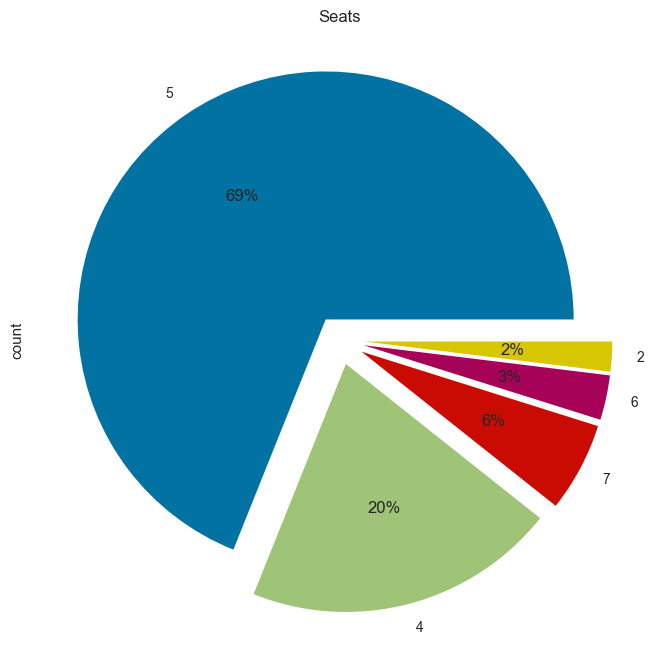

In [29]:
df['Seats'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1))
plt.title('Seats')

Majority of cars have 5 seats

In [30]:
df3= df[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= df[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= df[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df5.head()

TopSpeed_KmH
Range_Km              
95                   2
100                  1
130                  1
160                  1
170                  2

In [31]:
df3=df3.sort_values("TopSpeed_KmH",ascending = False).head(10)
df4=df4.sort_values("Range_Km",ascending = False).head(10)
df5=df5.sort_values("Range_Km",ascending = False).head(10)

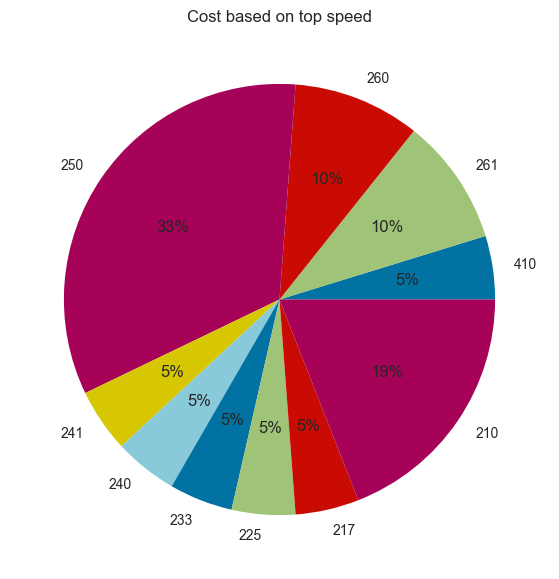

In [32]:
plt.figure(figsize=(10,7))
plt.title('Cost based on top speed')
plt.pie(x=df3["inr(10e3)"],labels=df3.index,autopct='%1.0f%%')
plt.show()

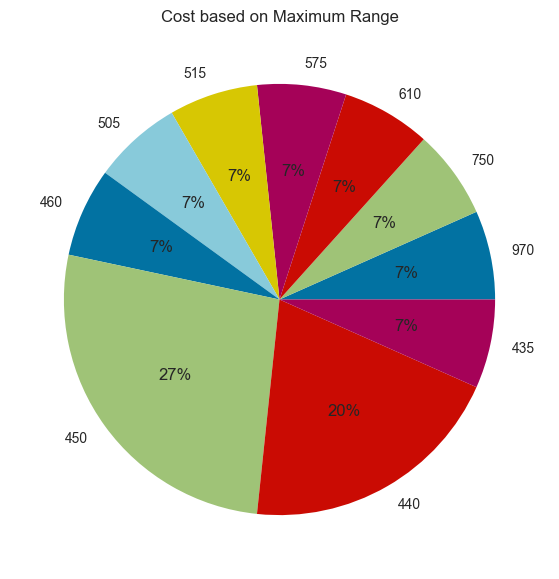

In [33]:
plt.figure(figsize=(10,7))
plt.title('Cost based on Maximum Range')
plt.pie(x=df4["inr(10e3)"],labels=df4.index,autopct='%1.0f%%')
plt.show()

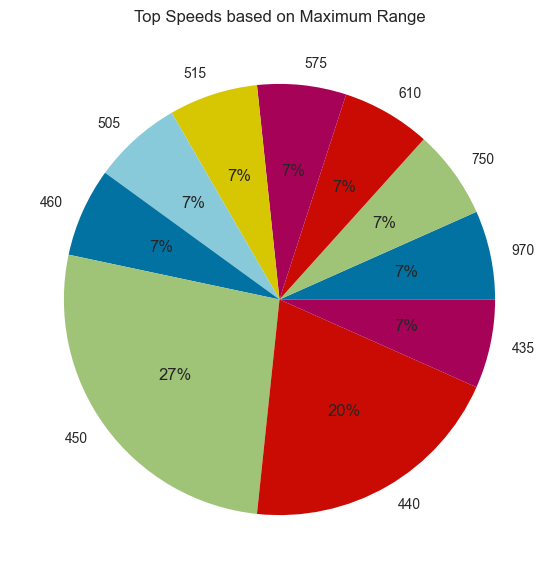

In [34]:
plt.figure(figsize=(10,7))
plt.title('Top Speeds based on Maximum Range')
plt.pie(x=df5["TopSpeed_KmH"],labels=df5.index,autopct='%1.0f%%')
plt.show()

## Clustering

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

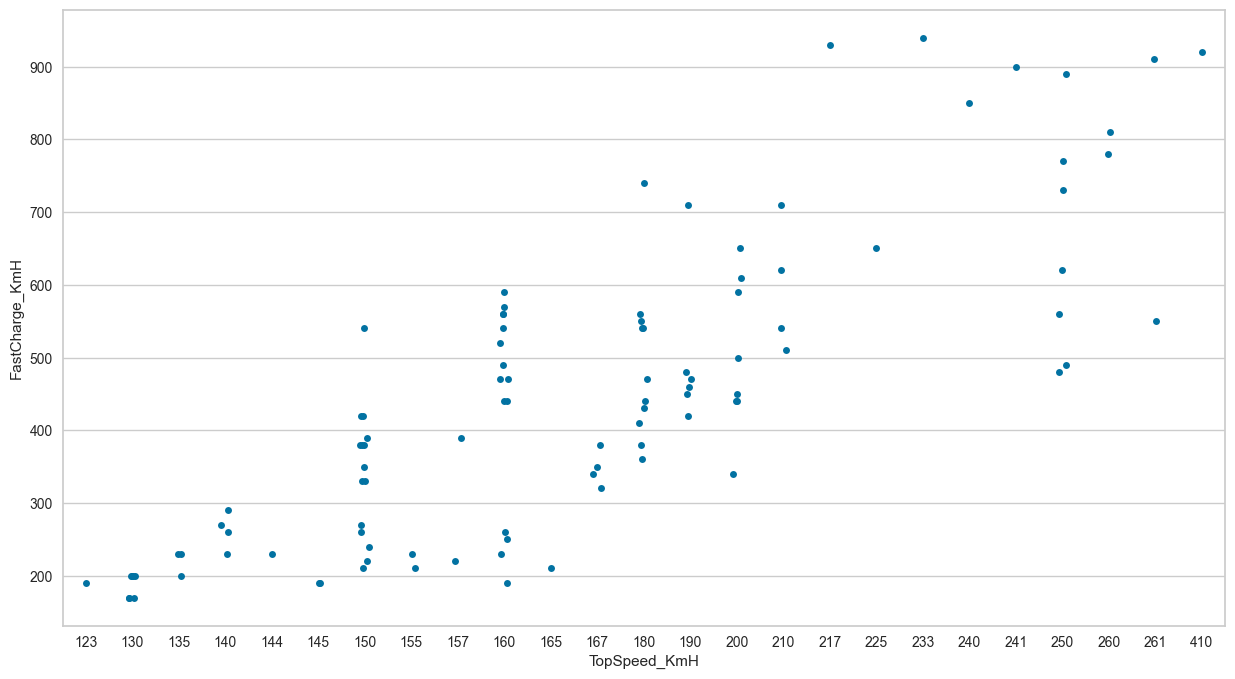

In [35]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=df, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

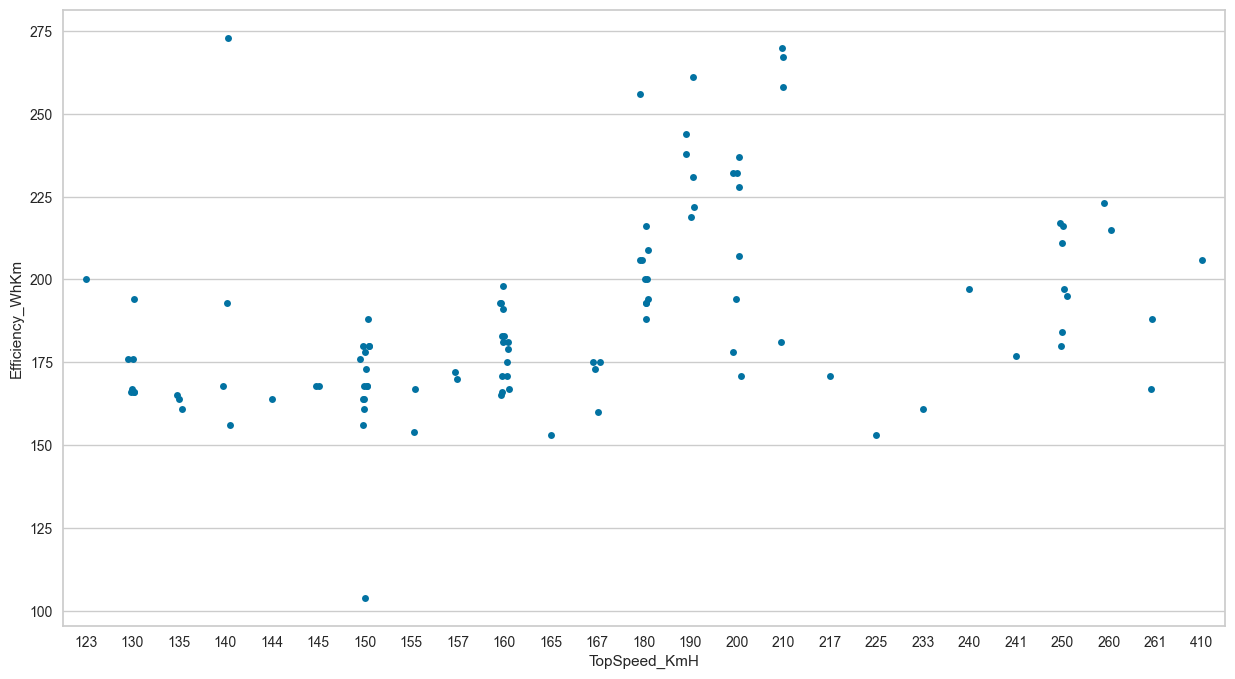

In [36]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=df, jitter=True)

In [37]:
features = ['AccelSec','TopSpeed_KmH','Efficiency_WhKm','FastCharge_KmH', 'RapidCharge','Range_Km', 'Seats', 'inr(10e3)','PowerTrain']
# Separating out the features
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [38]:
pca = PCA(n_components=9)
t = pca.fit_transform(x)
data2 = pd.DataFrame(t, columns=['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7', 'PC8','PC9'])
data2

PC1       PC2       PC3       PC4       Pc5       PC6       PC7  \
0    2.465733  0.274674 -1.236280 -1.056881 -1.287405  0.258839  0.450534   
1   -1.823744  0.528693  0.984377 -1.016025 -0.312594  0.447390 -0.305438   
2    1.624885  0.006621 -0.606593 -0.106583 -0.939586  0.129291  0.018337   
3    0.731122 -0.397782 -0.096029  0.410459  0.204130 -0.102410  0.229282   
4   -2.104819  0.559269 -0.775721  1.113435 -0.385495  0.339706 -0.274129   
..        ...       ...       ...       ...       ...       ...       ...   
98  -0.678370 -0.722302 -0.468886  0.096957  0.429857 -0.678485  0.192144   
99   2.357264 -0.261382  1.111871  1.748610  0.199780 -0.110804 -0.289612   
100  0.823000 -0.167425 -0.147821  0.571268 -0.808215  0.282138 -0.274538   
101  1.571839 -0.366536  0.608128  1.186537 -0.284638 -0.105687  0.025370   
102  0.985427  0.520722  2.396112 -0.028347 -0.088401  0.183098  0.429526   

          PC8       PC9  
0    0.894414 -0.359764  
1   -0.498355 -0.220781  
2   -0.082400 -0.177905  
3    0.438823  0.209826  
4   -0.339611 -0.087932  
..        ...       ...  
98   0.422362  0.152695  
99   0.205671  0.138711  
100 -0.381426 -0.348913  
101 -0.408375 -0.176441  
102 -0.294453 -0.170883  

[103 rows x 9 columns]

In [39]:
df_9=data2.iloc[:,:9]
df_9.head(3)

PC1       PC2       PC3       PC4       Pc5       PC6       PC7  \
0  2.465733  0.274674 -1.236280 -1.056881 -1.287405  0.258839  0.450534   
1 -1.823744  0.528693  0.984377 -1.016025 -0.312594  0.447390 -0.305438   
2  1.624885  0.006621 -0.606593 -0.106583 -0.939586  0.129291  0.018337   

        PC8       PC9  
0  0.894414 -0.359764  
1 -0.498355 -0.220781  
2 -0.082400 -0.177905

In [40]:
# correlation coefficient between original variables and the component
loadings = pca.components_
num_pc = 9
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_9.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

PC1       PC2       PC3       PC4       PC5       PC6  \
variable                                                               
PC1      -0.393923 -0.018883  0.081437 -0.014484  0.367262  0.673660   
PC2       0.416790  0.146855 -0.072256 -0.116010  0.156245 -0.030539   
PC3       0.235133 -0.209241  0.643415  0.571338  0.201325 -0.227935   
PC4       0.396444  0.055309 -0.073603 -0.223780 -0.239304  0.045720   
Pc5       0.140916 -0.437434 -0.695587  0.536195  0.030835  0.071691   
PC6       0.381704 -0.084511 -0.090573 -0.366400  0.281863 -0.126058   
PC7       0.116375 -0.809293  0.224465 -0.371208 -0.052579  0.219492   
PC8       0.381549  0.219813 -0.030779  0.069385  0.590638  0.303548   
PC9      -0.366027 -0.171676 -0.159278 -0.213224  0.557577 -0.574331   

               PC7       PC8       PC9  
variable                                
PC1       0.337336  0.181215 -0.319832  
PC2      -0.379322  0.066331 -0.782566  
PC3       0.208483  0.120815 -0.099864  
PC4       0.336327  0.773755  0.114491  
Pc5       0.085676  0.024673 -0.058378  
PC6       0.619273 -0.474368 -0.029071  
PC7      -0.296014  0.001451  0.068956  
PC8      -0.323751  0.036943  0.503155  
PC9      -0.049586  0.349953  0.006590

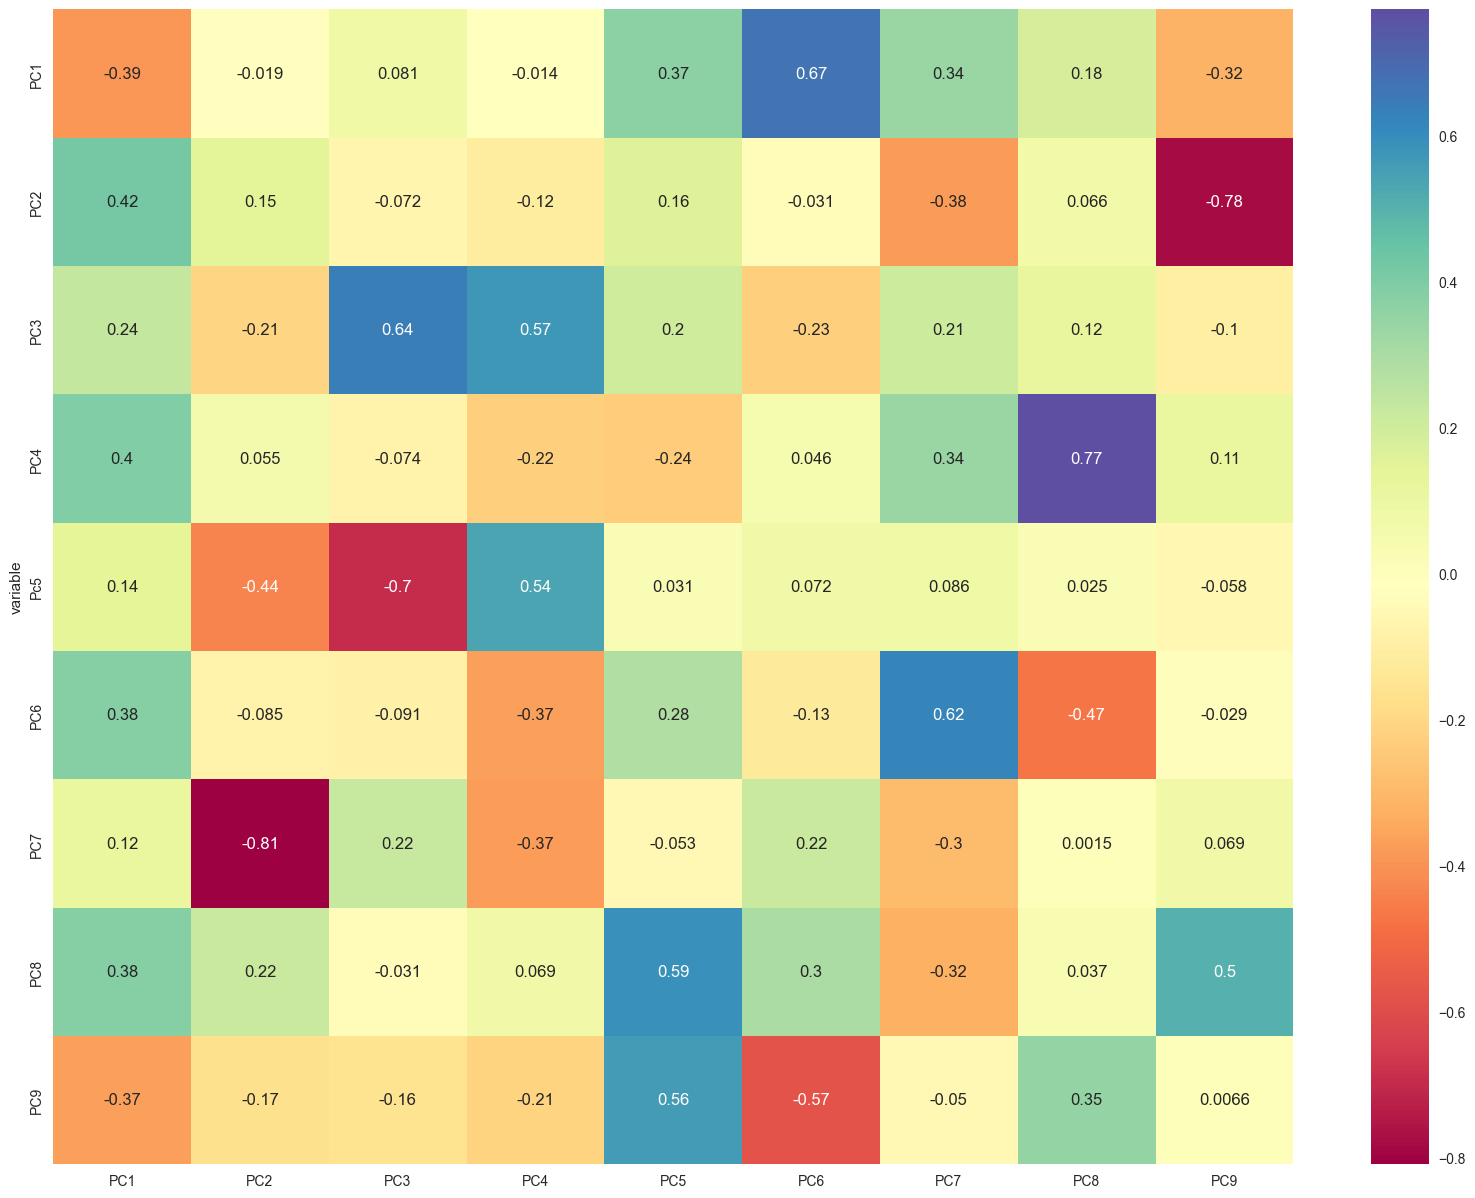

In [41]:
#Correlation matrix plot for loadings 
plt.rcParams['figure.figsize'] = (20,15)
ax = sb.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

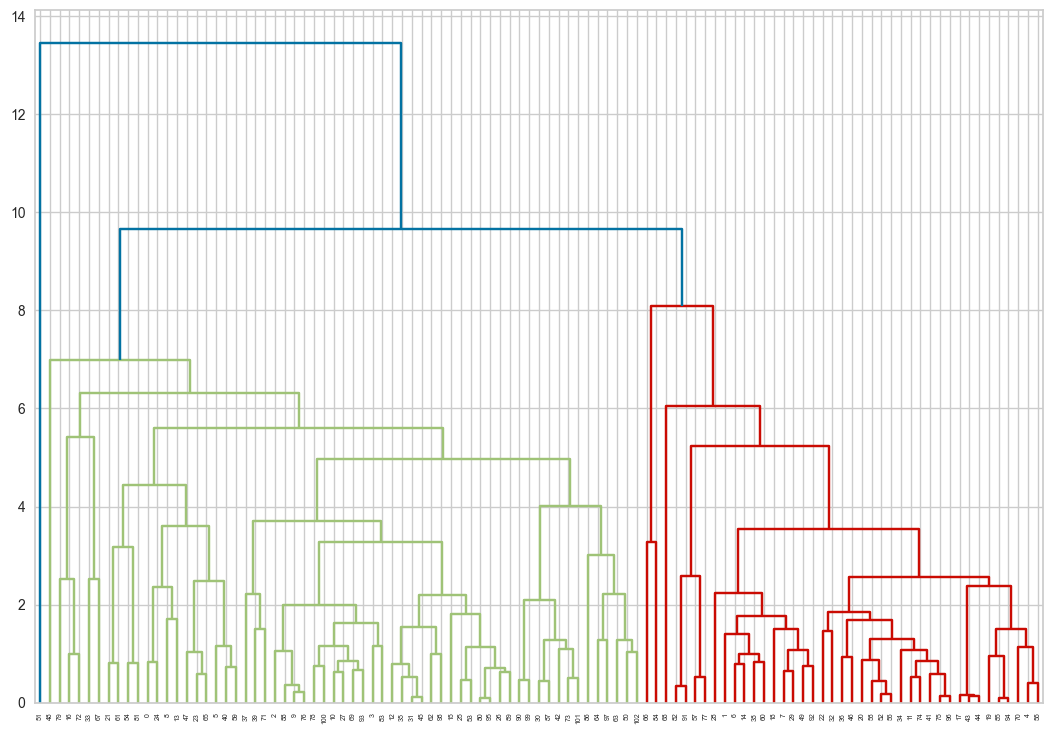

In [42]:
linked = linkage(data2, 'complete')
plt.figure(figsize=(13, 9))
dendrogram(linked, orientation='top')
plt.show()

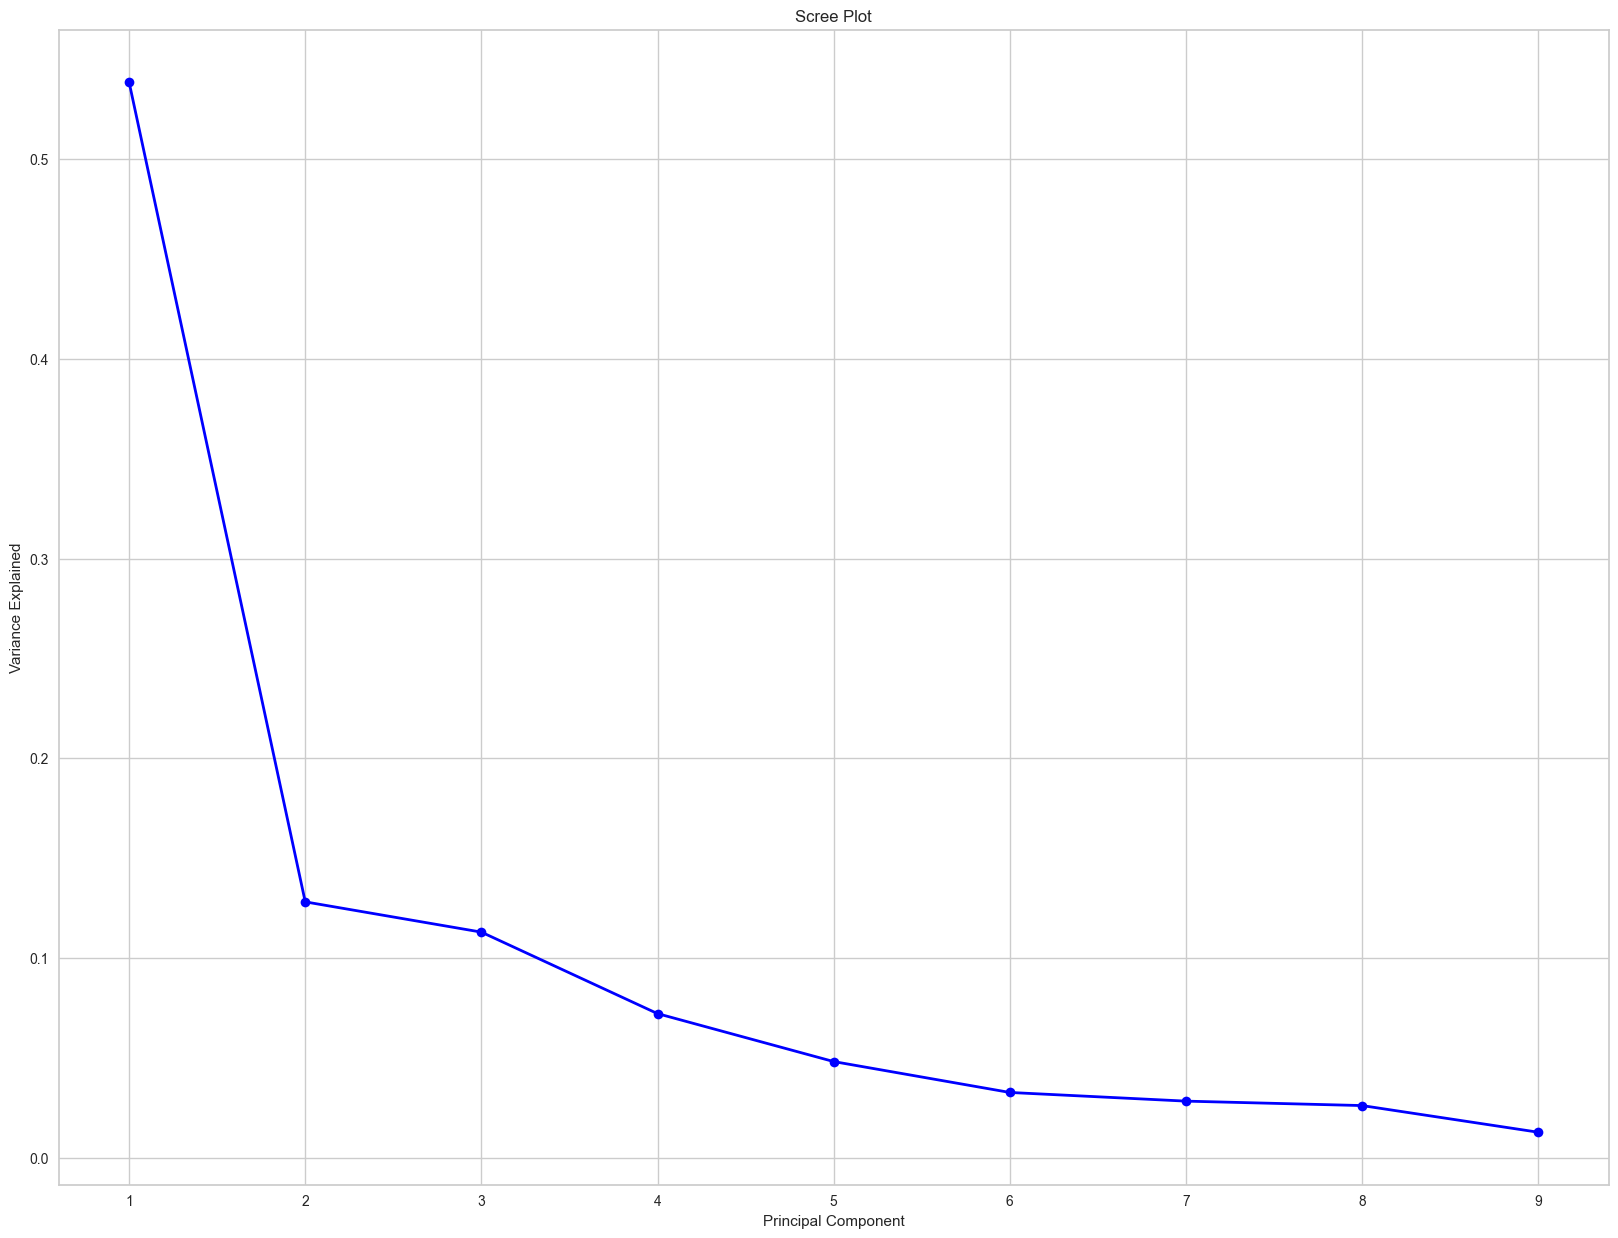

In [43]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

C:\Users\asifi\miniconda3\envs\basic\Lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning:

No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.

C:\Users\asifi\miniconda3\envs\basic\Lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning:

No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning



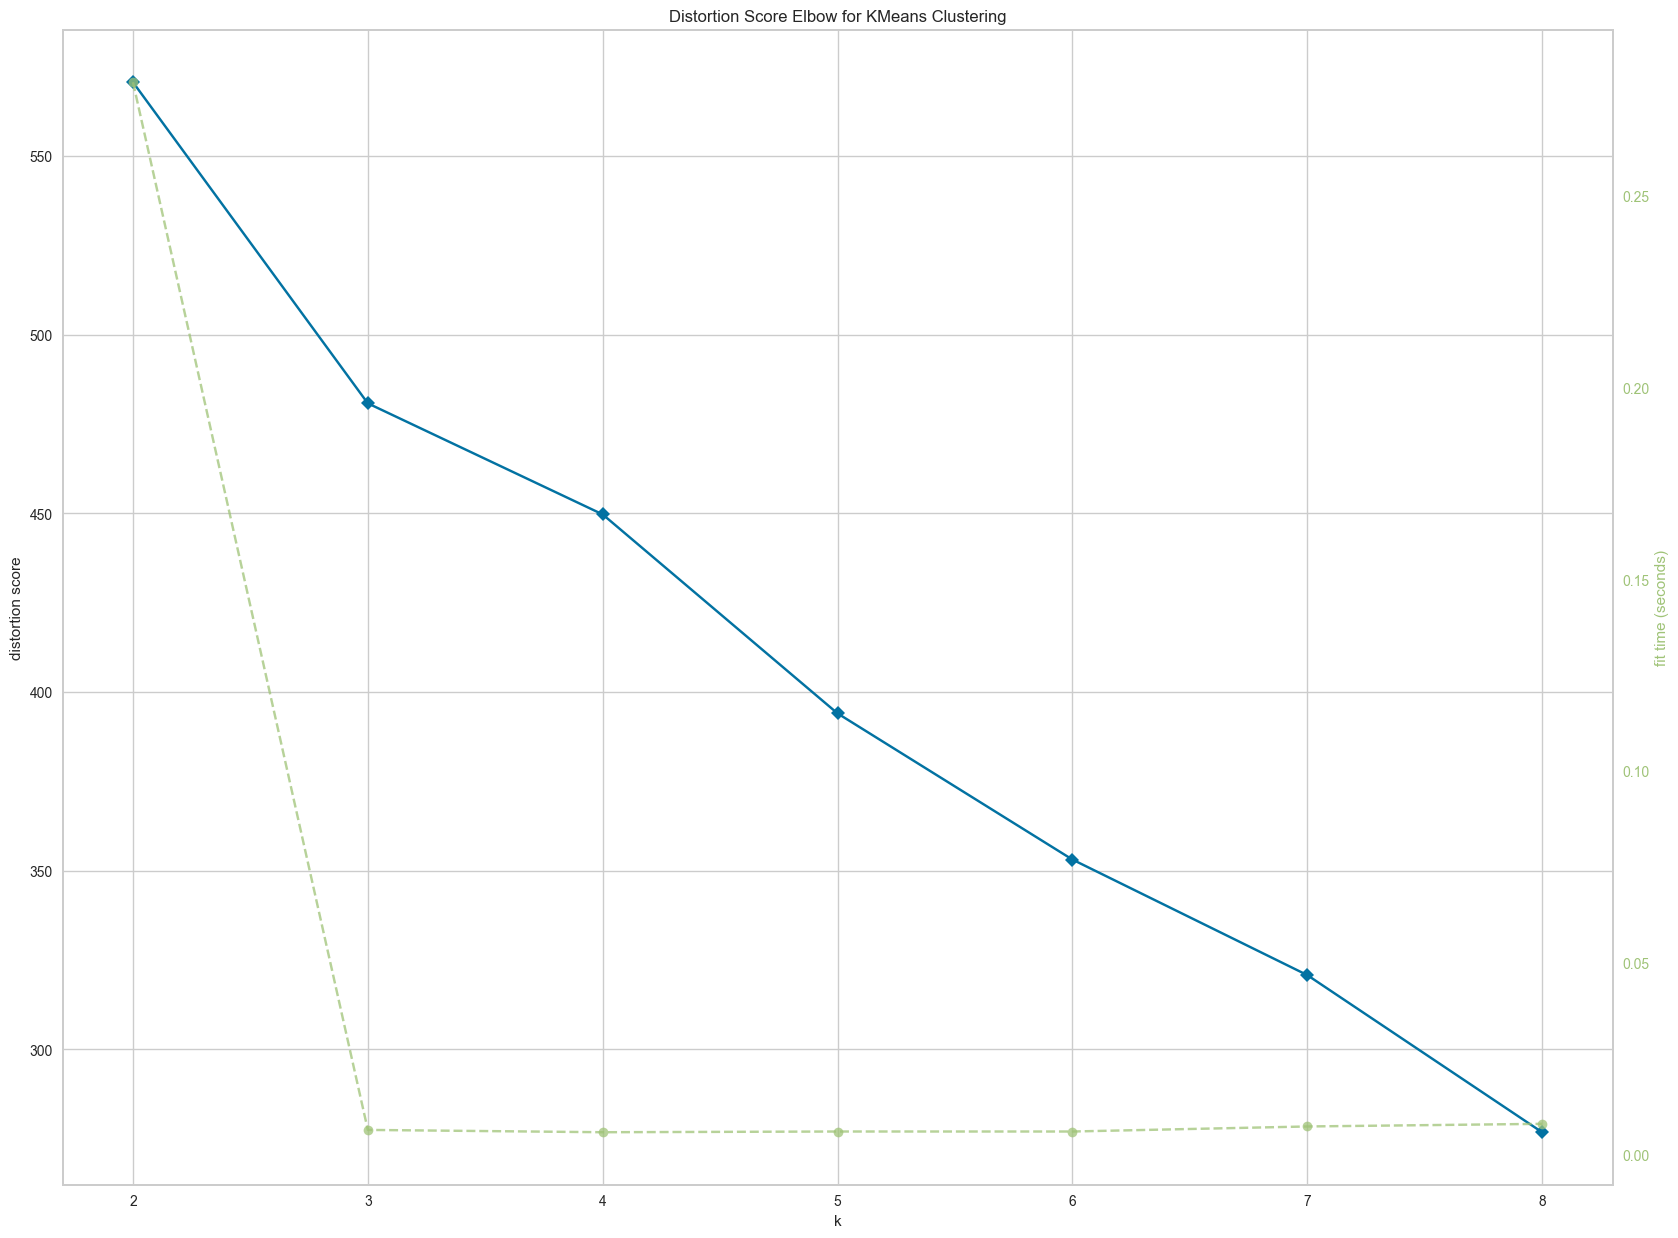

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [44]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='distortion', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

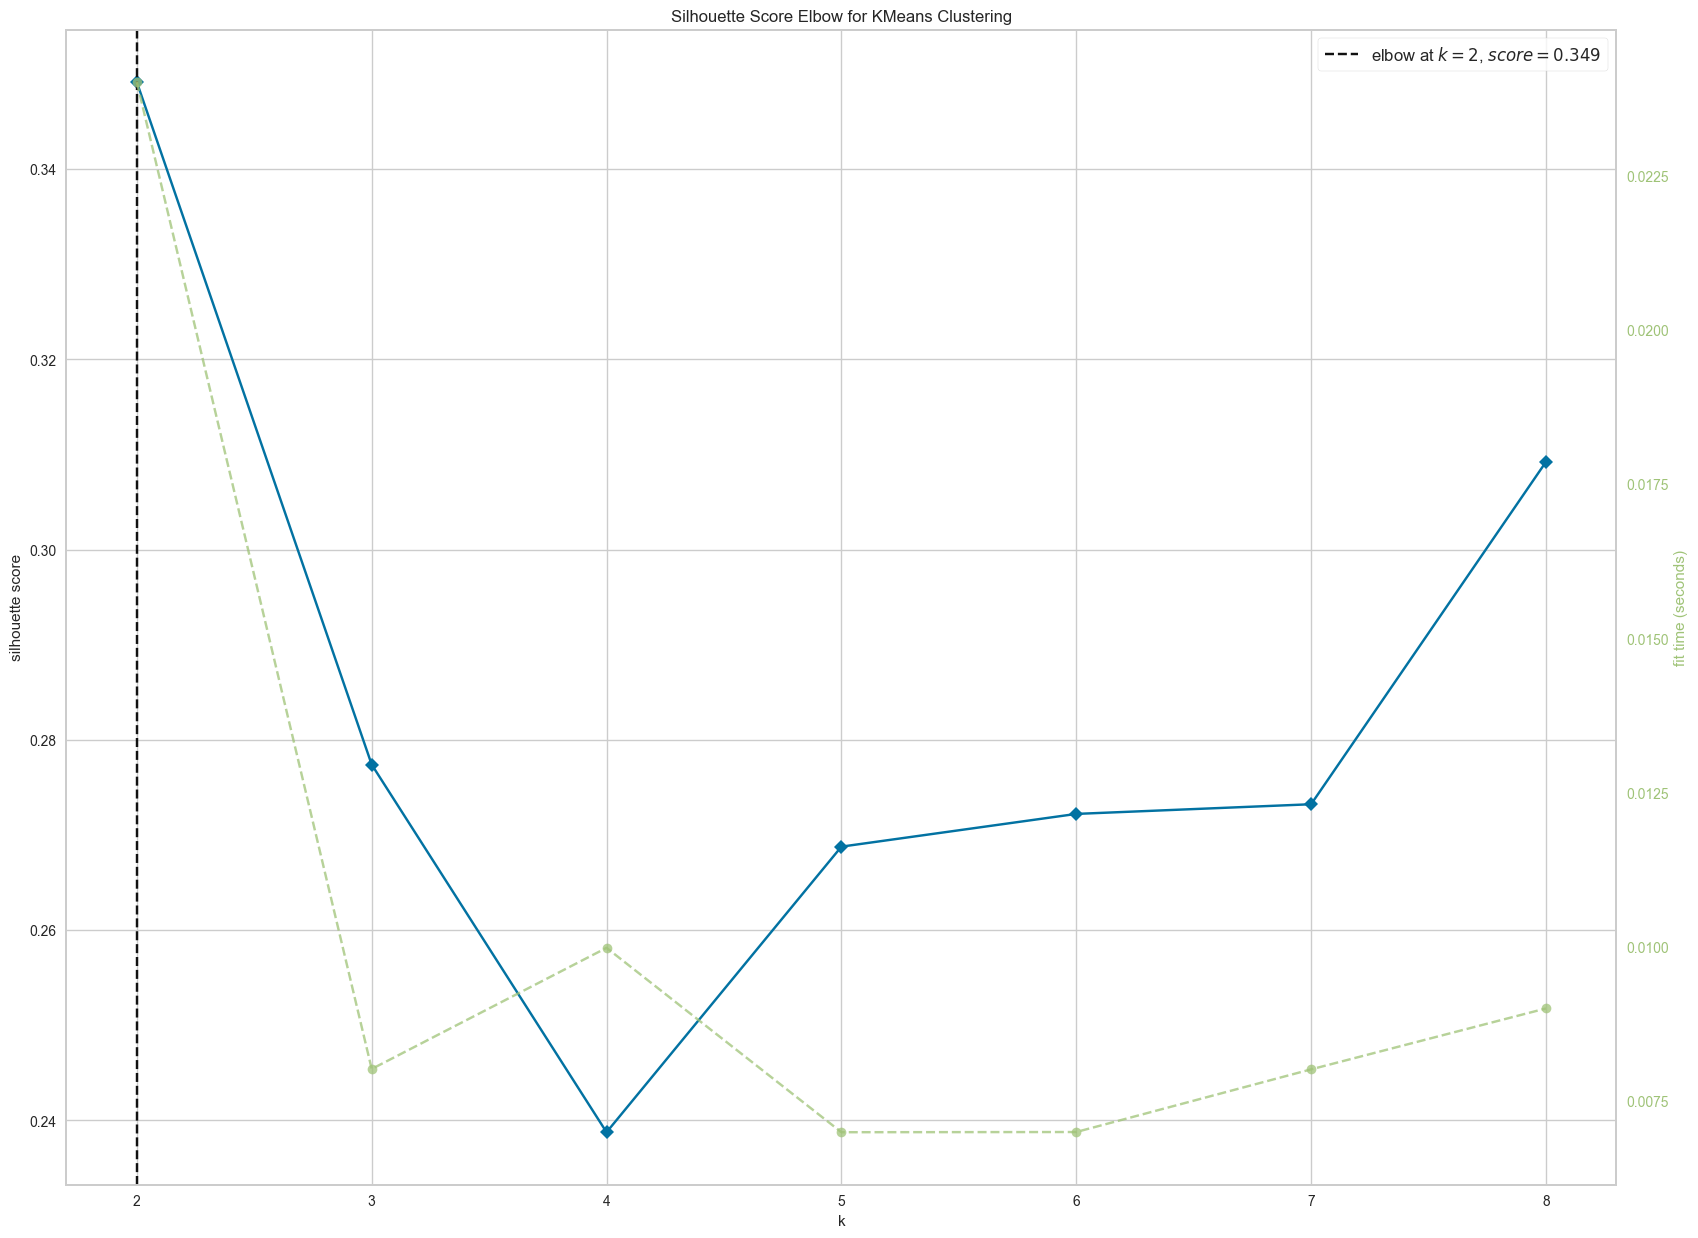

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [45]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='silhouette', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

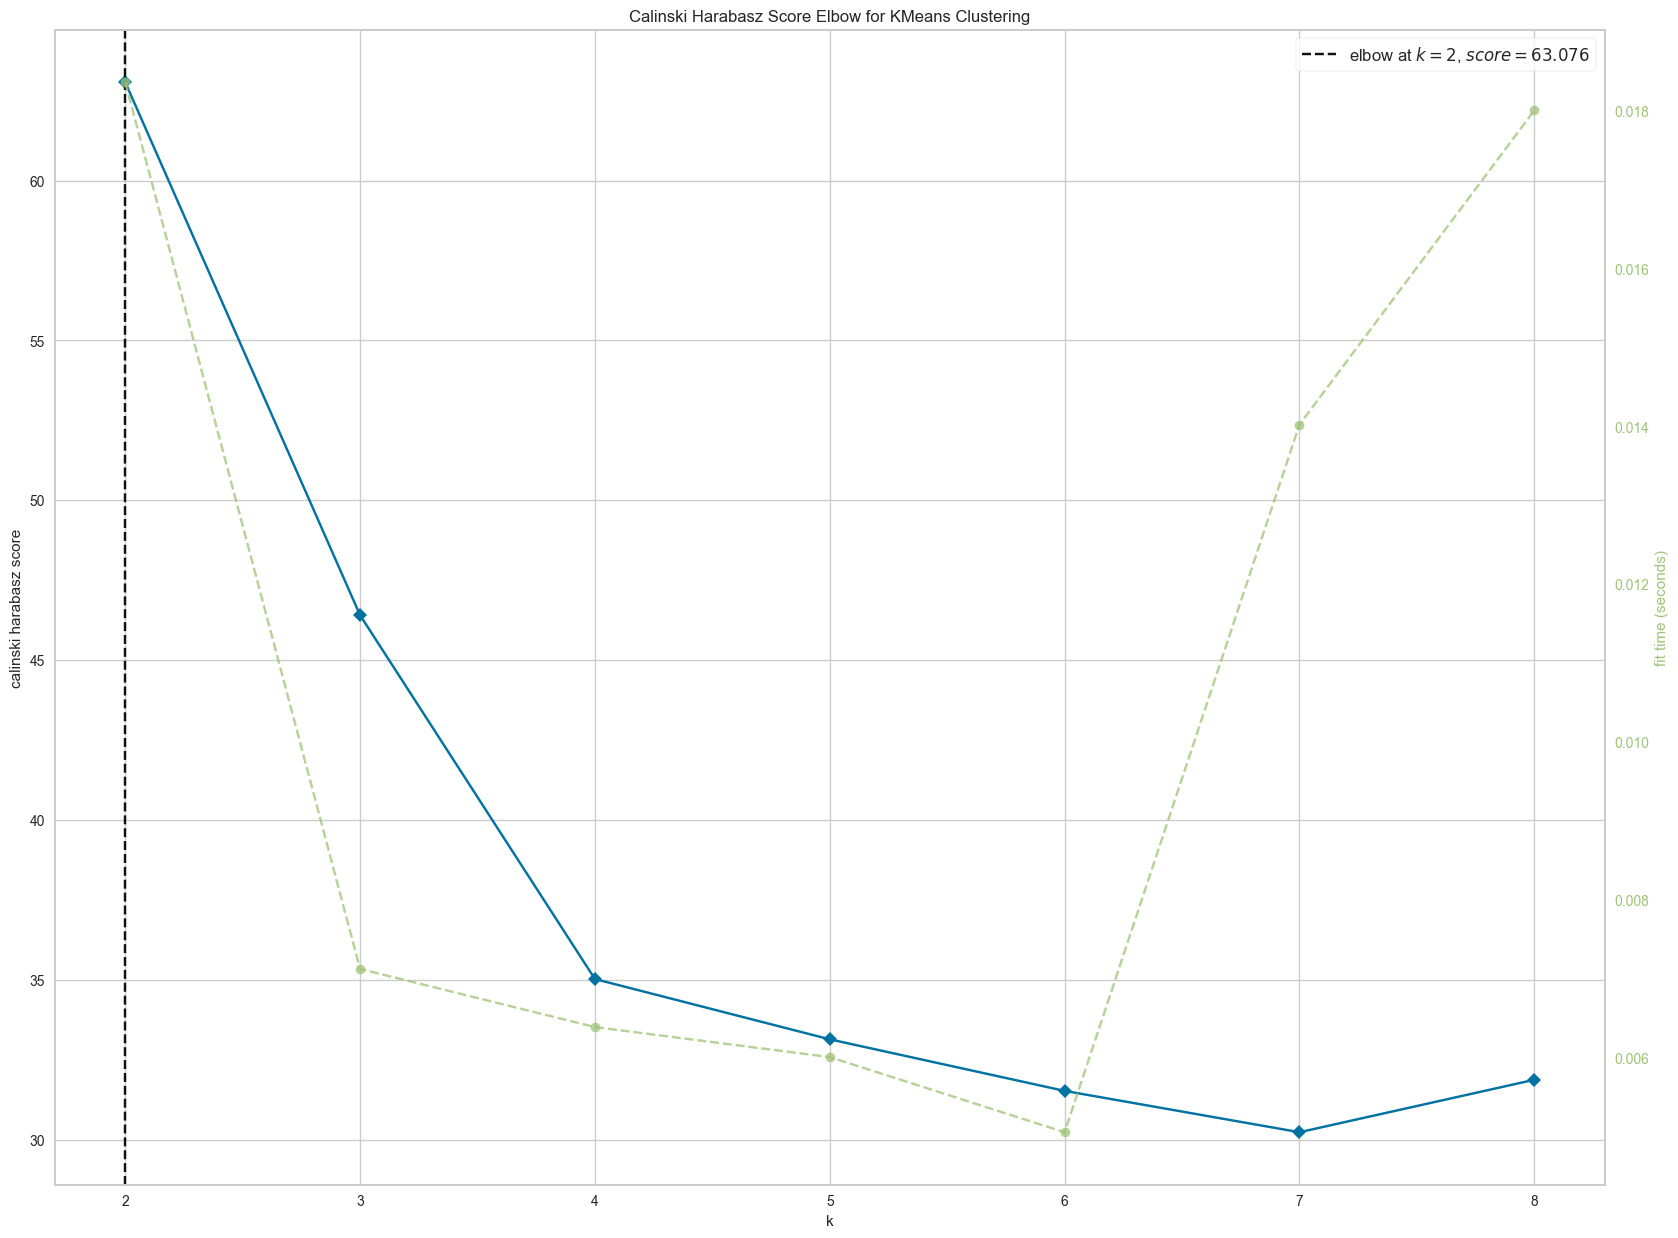

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [46]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='calinski_harabasz', timings=True)
visualizer.fit(t)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [47]:
#K-means clustering 

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(t)
df['cluster_num'] = kmeans.labels_ #adding to df
print (kmeans.labels_) #Label assigned for each data point
print (kmeans.inertia_) #gives within-cluster sum of squares. 
print(kmeans.n_iter_) #number of iterations that k-means algorithm runs to get a minimum within-cluster sum of squares
print(kmeans.cluster_centers_) #Location of the centroids on each cluster.

[1 0 3 3 0 1 0 0 3 3 3 0 0 3 0 0 1 0 0 0 0 3 0 1 1 3 0 3 0 0 3 0 0 3 0 0 0
 2 0 2 1 0 3 0 0 0 0 1 1 0 2 1 0 3 3 0 0 0 0 1 0 3 0 2 2 1 0 3 0 3 0 2 1 3
 0 0 3 0 3 1 0 3 0 3 3 0 2 3 3 0 3 0 0 3 0 0 0 2 0 3 3 3 2]
440.9360100448747
8
[[-1.8447365   0.01514546 -0.23403603 -0.06369168  0.13255341 -0.08653348
  -0.03105374  0.02321136 -0.01769795]
 [ 3.40990837  1.14563208 -0.77627899 -0.24254724  0.37428586  0.21661795
  -0.16985118  0.20232864  0.04780647]
 [ 0.63465143  0.56671931  1.78672906 -0.57285793 -0.27908435 -0.19351399
   0.19467008 -0.13883116  0.05529024]
 [ 1.46802966 -0.69220365  0.19823009  0.38523703 -0.30380603  0.11129334
   0.06799252 -0.08548572 -0.0072167 ]]


In [48]:
#To see each cluster size

Counter(kmeans.labels_)

Counter({0: 51, 3: 30, 1: 13, 2: 9})

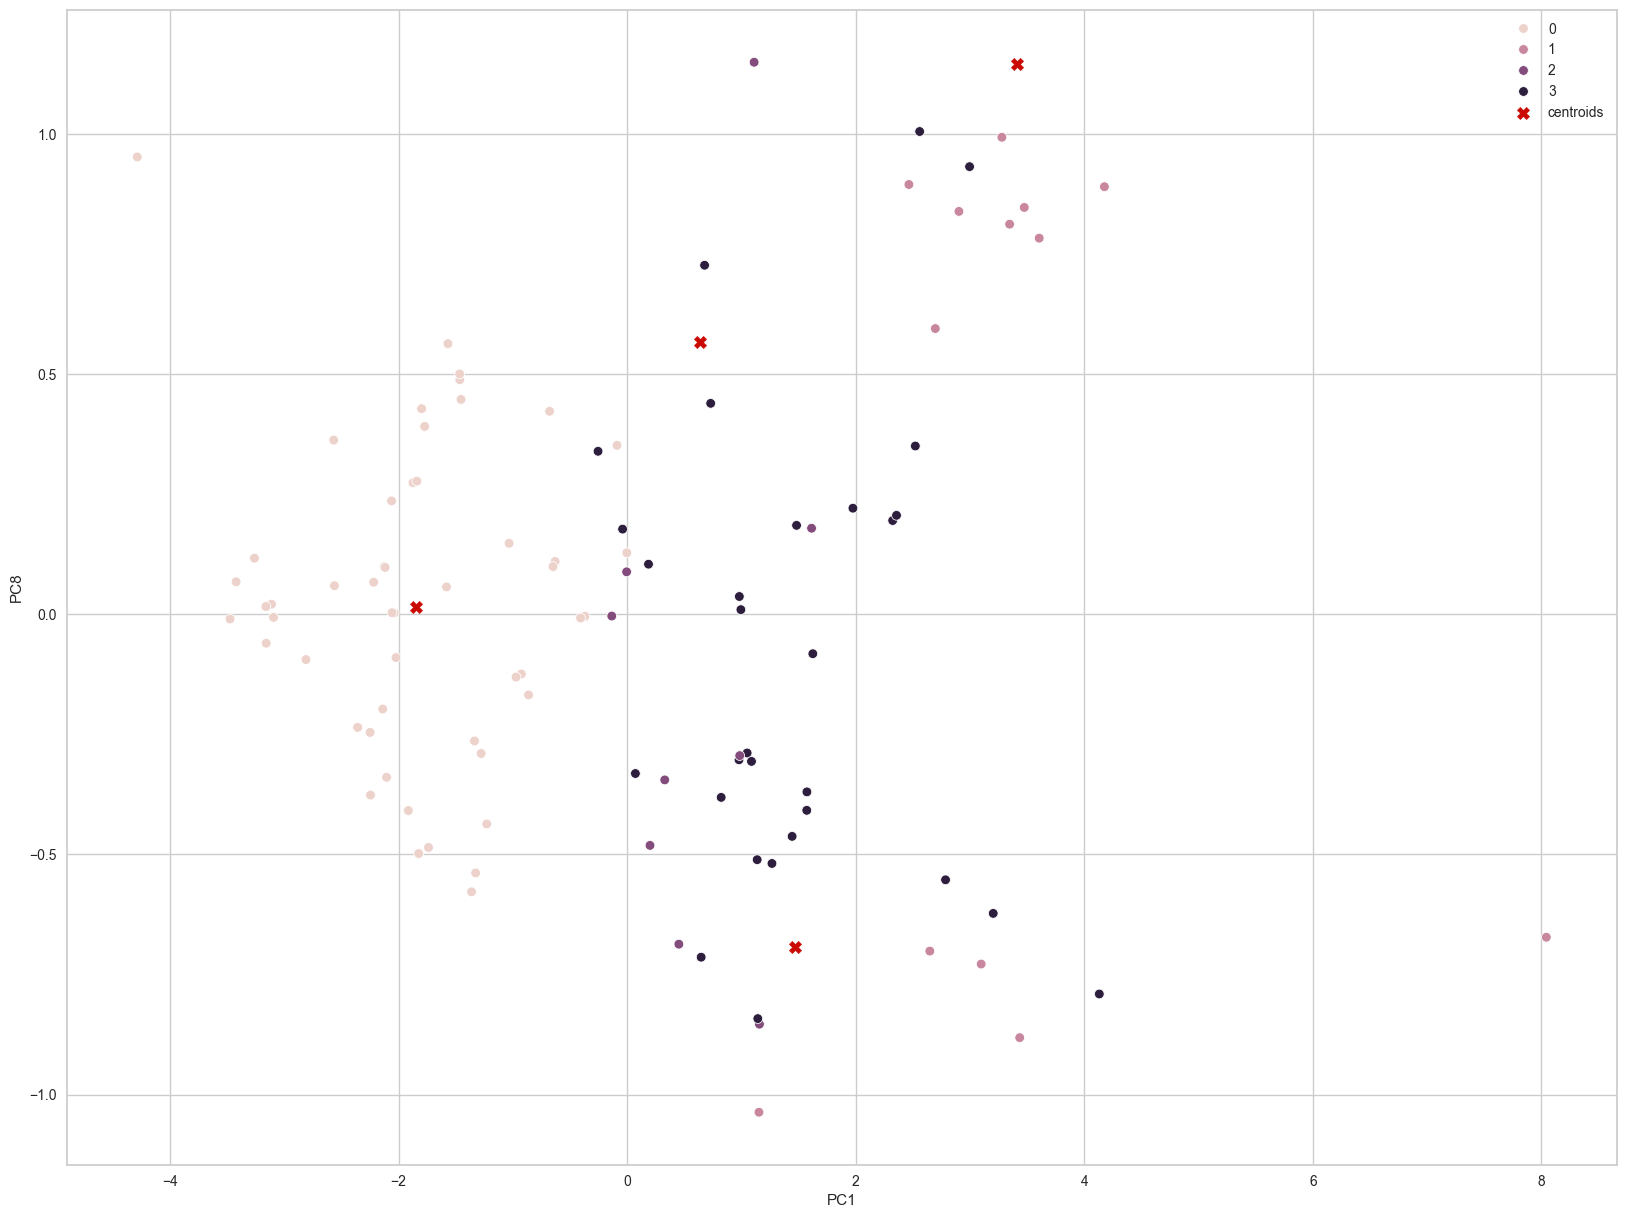

In [49]:
#Visulazing clusters
sb.scatterplot(data=data2, x="PC1", y="PC8", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()